# N26 Forecasting Task


### A Couple of points to note:

### - I have created a requirements.txt file from the virtual environment I used for this project and note I used python version 3.10.0, I believe you will run into errors with auto arima in later python versions, please set up your environment with this set up if you wish to replicate my code 

### - I never got time to seperate my models out into funtions in seperatate .py which is what I would do in a production setting

### - For some of the models at the end i have manually set the seasonal term P in my SARIMA model to 1, ignoring the output from auto arima, this is because I can clearly see at least and order 1 seasonal 7 day pattern in those cases

### - Some of the code at the bottom repeats itself quite often. In a production setting I would rewrite this using DRY code once I identify the best models from experimentation and seperate out in .py files, apologies if it makes reading through this notebook an arduous task 

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import random
import numpy as np
import pickle

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.arima_model import ARMA,ARIMA,ARMAResults,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima import auto_arima

%matplotlib inline

sns.set_style("darkgrid")
pd.set_option('display.max_rows', 500)

# 1. Data Preperation

### In the data preperation step I load the data, check for nulls, duplicates and outliers and also set the optimum python data types. 

In [190]:
# loading the data
data = pd.read_csv('n26_data/2016-09-19_79351_training.csv')
mcc_group_definitions = pd.read_csv('n26_data/mcc_group_definition.csv')
trans_types = pd.read_csv('n26_data/transaction_types.csv')

In [191]:
# merging data into the single dataframe and then deleting the unnesecary objects from memory
data = data.merge(mcc_group_definitions, how='left',on='mcc_group')
data = data.merge(trans_types, how='left',left_on='transaction_type', right_on='type')

del mcc_group_definitions
del trans_types

In [192]:
# having a quick look at the head of the dataset
data.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user,explanation_x,type,explanation_y,direction,agent
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,training,training,NaN,DT,Debit Transfer,Out,Bank Account
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,training,training,NaN,DT,Debit Transfer,Out,Bank Account
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291,training,training,NaN,DT,Debit Transfer,Out,Bank Account
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214,training,training,NaN,DT,Debit Transfer,Out,Bank Account
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272,training,training,NaN,DT,Debit Transfer,Out,Bank Account


In [193]:
# having a quick look at the dataframe information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408546 entries, 0 to 408545
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              408546 non-null  object 
 1   transaction_date     408546 non-null  object 
 2   transaction_type     408546 non-null  object 
 3   mcc_group            258324 non-null  float64
 4   amount_n26_currency  408546 non-null  int64  
 5   dataset_transaction  408546 non-null  object 
 6   dataset_user         408546 non-null  object 
 7   explanation_x        258324 non-null  object 
 8   type                 408546 non-null  object 
 9   explanation_y        408546 non-null  object 
 10  direction            408546 non-null  object 
 11  agent                408546 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 40.5+ MB


In [194]:
# the two explanation collumns need to be renamed and i can get rid of the original type and mcc_group columns
data = data.drop(['mcc_group','type','transaction_type'],axis=1)

data = data.rename(columns={'explanation_x':'mcc_group',
                            'explanation_y': 'trans_type'})

In [195]:
# before i drop the the two superfluos collumns I double check content
print(data['dataset_transaction'].unique())
print(data['dataset_user'].unique())

['training']
['training']


In [196]:
# confirmed from last step that the two collumns can be dropped
data = data.drop(['dataset_transaction','dataset_user'],axis=1)

In [197]:
# The collumn mcc_group contains null values, however this is because 
# it is only relevant for card payments checking if there are missing 
# values when I filter on card
print(data[data['agent'] == 'Card']['mcc_group'].value_counts())
print("--------------------------")
print(data[data['agent'] != 'Card']['mcc_group'].value_counts()) 

ATM                           69807
Groceries                     50586
Travel/Hotel                  24672
Gastronomie                   20875
Automotive/Gas                20610
Shopping/(Fashion)            20194
Business Expenses             11466
Miscellaneous                 11150
Transport                     10888
Entertainment/Leisure          7282
Drugstore                      5803
Home and DIY, House Energy     3337
Finance                         873
Education                       329
Family/Babies/Children          287
Insurance                       141
Taxes and Fines                  24
Name: mcc_group, dtype: int64
--------------------------
Series([], Name: mcc_group, dtype: int64)


In [198]:
# setting data types to optimise for efficiency
data = data.astype({'user_id':'category',
                    'transaction_date':'datetime64',
                    'mcc_group':'category',
                    'trans_type':'category',
                    'direction':'category',
                    'agent':'category'
                    })

In [199]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408546 entries, 0 to 408545
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   user_id              408546 non-null  category      
 1   transaction_date     408546 non-null  datetime64[ns]
 2   amount_n26_currency  408546 non-null  int64         
 3   mcc_group            258324 non-null  category      
 4   trans_type           408546 non-null  category      
 5   direction            408546 non-null  category      
 6   agent                408546 non-null  category      
dtypes: category(5), datetime64[ns](1), int64(1)
memory usage: 12.0 MB


### Notice the size of the data is almost a quarter of the original dataframe, I did have a debate in my mind about setting the direction column to boolean however decided against because in reality a third option of neither in or out is possible in the data 

In [200]:
data[data.duplicated()]

,user_id,transaction_date,amount_n26_currency,mcc_group,trans_type,direction,agent
52,d676b47c24ee99835d24e38953cf7ab6,2016-02-01,15,NaN,Debit Transfer,Out,Bank Account
70,ce8150cf1461297516d4f65d8258a36b,2016-02-01,5,NaN,Debit Transfer,Out,Bank Account
84,ce8150cf1461297516d4f65d8258a36b,2016-02-01,5,NaN,Debit Transfer,Out,Bank Account
93,ea589a947c4c128a6c6b81fb35605d40,2016-02-01,5,NaN,Debit Transfer,Out,Bank Account
102,dc879d41982dfa14abb14d96818eadd2,2016-02-01,19,NaN,Debit Transfer,Out,Bank Account
...,...,...,...,...,...,...,...
408296,dd99d81a087d354cc6131ec386800d22,2016-07-31,19,NaN,Debit Transfer,Out,Bank Account
408300,b6caa44ddab07f100ad5fc4927fd563e,2016-07-31,19,ATM,Presentment,Out,Card
408307,c00d31436e6a8aabc179b8f138a3ffd4,2016-07-31,194,ATM,Presentment,Out,Card
408493,3967d1c646a5c68aa3e64294cd77b263,2016-07-31,5,NaN,Debit Transfer,Out,Bank Account


### In the previous step I wanted to check if there are duplicates, you will notice that there are, however given the nature of the data it is perfectly possible that customers will make the same transaction more than once, without a unique identifier for each transaction I cannot distinguish between repeat transactions and duplicates with 100% certainty, I recieved confirmation from data owner that I can remove them, in the real world I would ensure a tranction id is added, especially if I am building a solution that will later go into production

In [201]:
# dropping duplicates
data = data.drop_duplicates(keep='first')

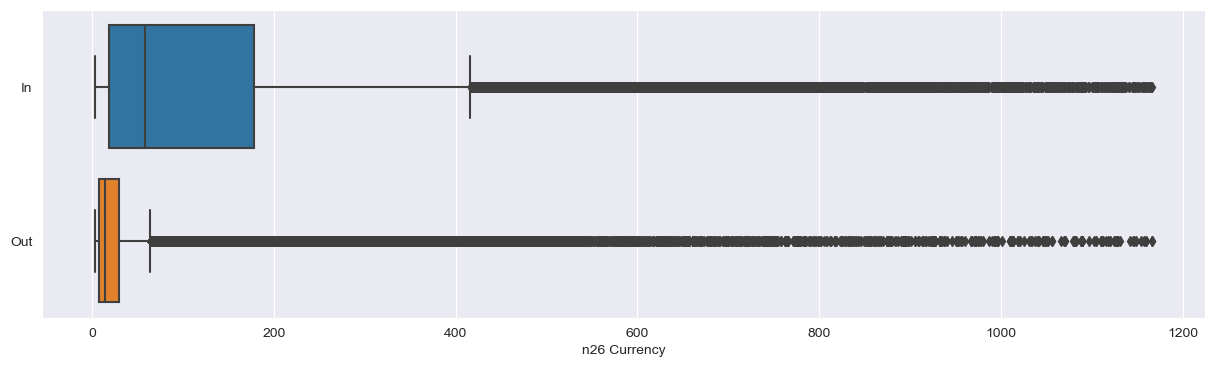

In [202]:
# plotting box and whisker plot to check for outliers
fig, ax = plt.subplots(figsize=(15,4))
sns.boxplot(data=data, 
            x='amount_n26_currency',
            y='direction',
            ax=ax, 
            )
# ax.set(xlim=(0, 800))
plt.xlabel("n26 Currency")
plt.ylabel("")
plt.show()

### In this data there are a significant number of outliers as you can see from the box and whisker plot, however given the nature of what the data represents, you would expect a pareto distribution in both income and outgoings and there is isnt anything that is really outlandish

In [203]:
print(data.shape)

(398321, 7)


# 2. Exploratory Data Analysis

### In this step I explore the data column by column in order to gain a better understanding of the data. This knowledge is then used to inform some of the decisions made when building my forecasting model. 

In [204]:
# checking number of unique values by column 
print(data.nunique())

user_id                10000
transaction_date         182
amount_n26_currency     1127
mcc_group                 17
trans_type                 9
direction                  2
agent                      3
dtype: int64


In [205]:
# having a look at the data range 
data['transaction_date'].describe()

/var/folders/jk/7_97xl9d43v9l_jqg7kbpf9m0000gn/T/ipykernel_5982/4123954555.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['transaction_date'].describe()


count                  398321
unique                    182
top       2016-07-06 00:00:00
freq                     5203
first     2016-02-01 00:00:00
last      2016-07-31 00:00:00
Name: transaction_date, dtype: object

In [206]:
# income summary
data[data['direction']=='In']['amount_n26_currency'].describe()

count    70667.000000
mean       140.807774
std        196.938020
min          3.000000
25%         19.000000
50%         58.000000
75%        178.000000
max       1166.000000
Name: amount_n26_currency, dtype: float64

In [207]:
# expenditure summary
data[data['direction']=='Out']['amount_n26_currency'].describe()

count    327654.000000
mean         34.235587
std          71.071162
min           3.000000
25%           7.000000
50%          14.000000
75%          30.000000
max        1166.000000
Name: amount_n26_currency, dtype: float64

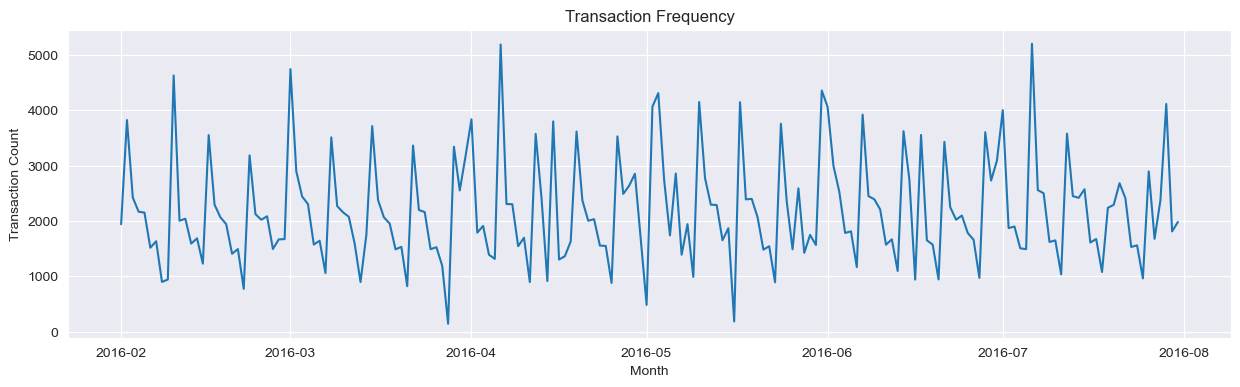

In [208]:
# plot of transaction frequency
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=data.pivot_table(index='transaction_date',values='amount_n26_currency',aggfunc='count'), 
            x='transaction_date',
            y='amount_n26_currency',
            ax=ax, 
            estimator='count',
            )
plt.xlabel("Month")
plt.ylabel("Transaction Count")
plt.title('Transaction Frequency')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

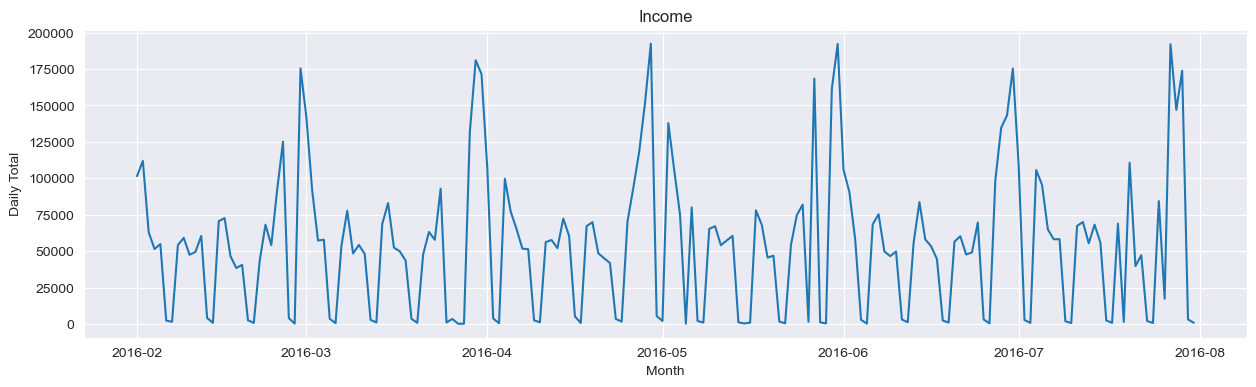

In [209]:
# plot of daily income
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=data.pivot_table(index='transaction_date',values='amount_n26_currency',columns='direction',aggfunc='sum'), 
            x='transaction_date',
            y='In',
            ax=ax, 
            estimator='sum'
            )
plt.xlabel("Month")
plt.ylabel("Daily Total")
plt.title('Income')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

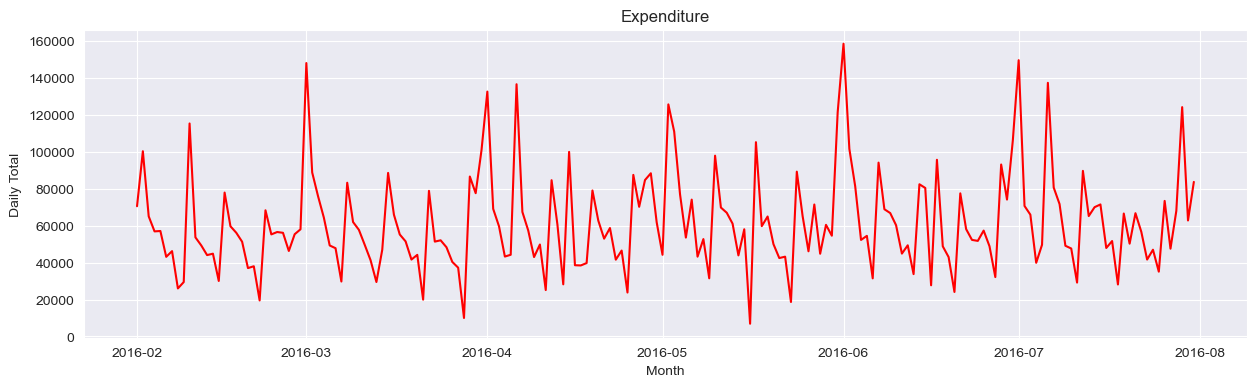

In [210]:
# plot of daily expenditure
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=data.pivot_table(index='transaction_date',values='amount_n26_currency',columns='direction',aggfunc='sum'), 
            x='transaction_date',
            y='Out',
            ax=ax, 
            estimator='sum',
            color='red'
            )
plt.xlabel("Month")
plt.ylabel("Daily Total")
plt.title('Expenditure')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

### Looking at the data I can see a couple of things immediately, visually there doesnt appear to be a trend, however there deos appear to be seasonality in the data, it looks like there is a weekly pattern to the data 

In [211]:
# examining monthly aggregation 
data['month'] = data['transaction_date'].dt.month_name()
data["month"] = pd.Categorical(data["month"],
                               categories=["February",
                                           "March",
                                           "April",
                                           "May",
                                           "June",
                                           "July",
                                           ],
                             ordered=True)

In [212]:
# monthly transaction count total 
data['month'].value_counts()

May         69935
July        69244
June        68327
April       66357
March       66007
February    58451
Name: month, dtype: int64

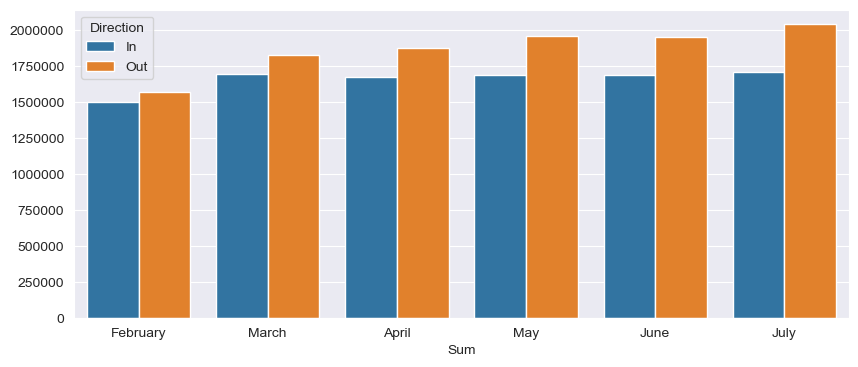

In [213]:
# plotting sum of monthly transactions, split income and outcome
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=data, 
            x='month',
            y='amount_n26_currency',
            ax=ax, 
            estimator='sum',
            hue='direction',
            errorbar=None
            )
plt.xlabel("Sum")
plt.ylabel("")
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title='Direction', loc='upper left', labels=['In','Out'])
plt.show()

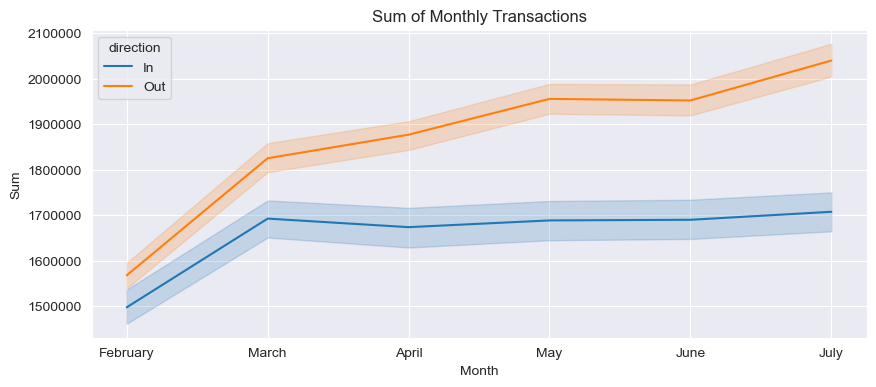

In [214]:
# replotted chart above as line chart
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=data, 
            x='month',
            y='amount_n26_currency',
            ax=ax, 
            estimator='sum',
            hue='direction',
            )
plt.xlabel("Month")
plt.ylabel("Sum")
plt.ticklabel_format(style='plain', axis='y')
plt.title('Sum of Monthly Transactions')
# plt.legend(title='Direction', loc='upper left', labels=['In','Out'])
plt.show()

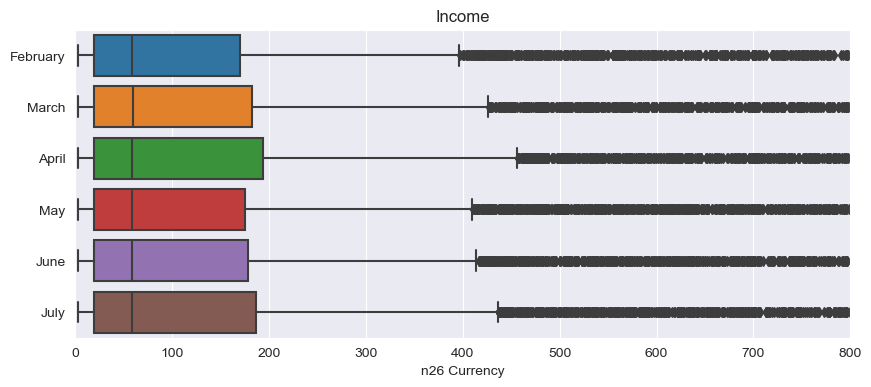

In [215]:
# plotting box and whisker plot for Income
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(data=data[data['direction']=='In'], 
            x='amount_n26_currency',
            y='month',
            ax=ax, 
            )
ax.set(xlim=(0, 800))
plt.xlabel("n26 Currency")
plt.ylabel("")
plt.title('Income')
plt.show()

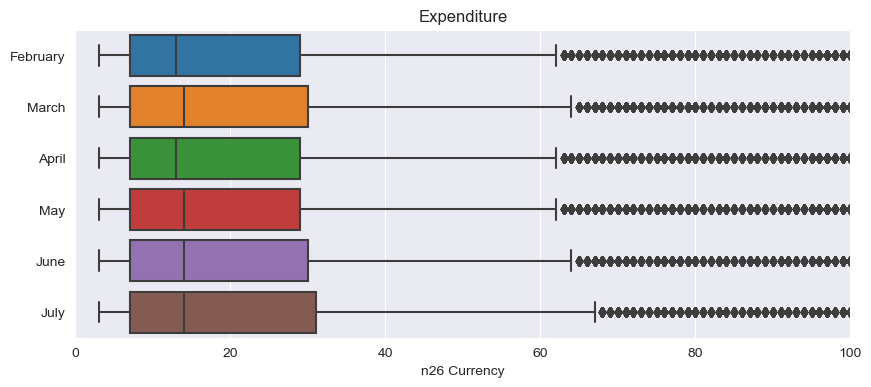

In [216]:
# plotting box and whisker plot for Expenditure
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(data=data[data['direction']=='Out'], 
            x='amount_n26_currency',
            y='month',
            ax=ax, 
            )
ax.set(xlim=(0, 100))
plt.xlabel("n26 Currency")
plt.ylabel("")
plt.title("Expenditure")
plt.show()

### In both income and expenditure I can see that the real changes month by month occur in the top quartile and beyond 

In [217]:
# Looking into monthly flow 
monthly_flow = (data
    .pivot_table(values='amount_n26_currency', 
                 index=['user_id','month'],
                 columns=['direction'],
                 aggfunc='sum')
)

monthly_flow.describe()

direction,In,Out
count,60000.000000,60000.000000
mean,165.841050,186.957117
std,319.196059,369.864871
min,0.000000,0.000000
25%,0.000000,0.000000
50%,17.000000,44.000000
75%,194.000000,213.000000
max,6189.000000,8528.000000


In [218]:
# having a look to see how many instances of zero transactions their are
print(len(monthly_flow[monthly_flow['In'] == 0]))
print(len(monthly_flow[monthly_flow['Out'] == 0]))

27614
19087


In [219]:
# following previous cell am looking to see how many unique customers made a transaction by month
months = ["February","March","April","May","June","July"]
no_users = dict()

for month in months:
    mask1 = monthly_flow.loc[(slice(None), month), :]['In'] != 0
    mask2 = monthly_flow.loc[(slice(None), month), :]['Out'] != 0
    no_users[month] = len(monthly_flow.loc[(slice(None), month), :][mask1 | mask2])

print(no_users)

{'February': 7188, 'March': 7438, 'April': 7402, 'May': 7404, 'June': 7398, 'July': 7384}


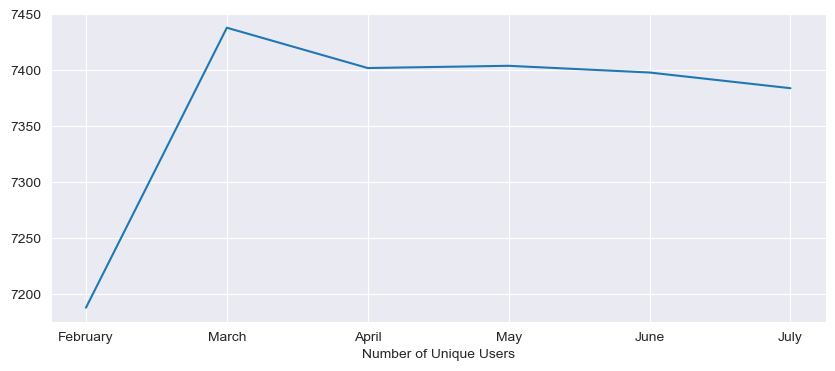

In [220]:
# plotting data from previous cell
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot( 
            x=list(no_users.keys()),
            y=list(no_users.values()),
            ax=ax, 
            errorbar=None
            )
plt.xlabel("Number of Unique Users")
plt.ylabel("")
plt.show()

In [221]:
# looking at breakdown of transaction type for income 
(data[data['direction']=='In']
    .groupby('trans_type')
    .agg({'amount_n26_currency':['count','sum']})
    .sort_values(by=('amount_n26_currency','count'),ascending=False)
)

amount_n26_currency         
                                       count      sum
trans_type                                           
Credit Transfer                        62544  9387753
Debit Reversal                          4572   160243
Cash26 deposit                          3551   402467
Cash26 withdrawal                          0        0
Debit Transfer                             0        0
Direct Debit                               0        0
MoneyBeam Transfer                         0        0
Presentment                                0        0
Transferwise Transaction                   0        0

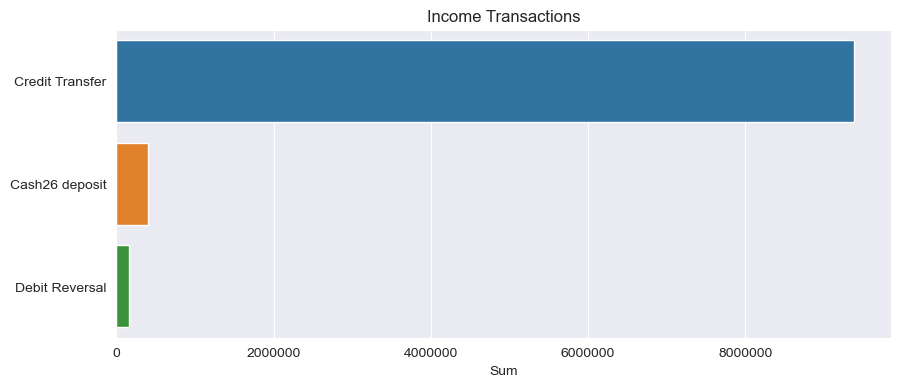

In [367]:
# plotting data on bar
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=data[data['direction']=='In'], 
            y='trans_type',
            x='amount_n26_currency',
            ax=ax, 
            # palette='bright',
            estimator='sum',
            errorbar=None,
            order=['Credit Transfer','Cash26 deposit','Debit Reversal']
            )
plt.xlabel("Sum")
plt.ylabel("")
plt.title("Income Transactions")
plt.ticklabel_format(style='plain', axis='x')
plt.show()

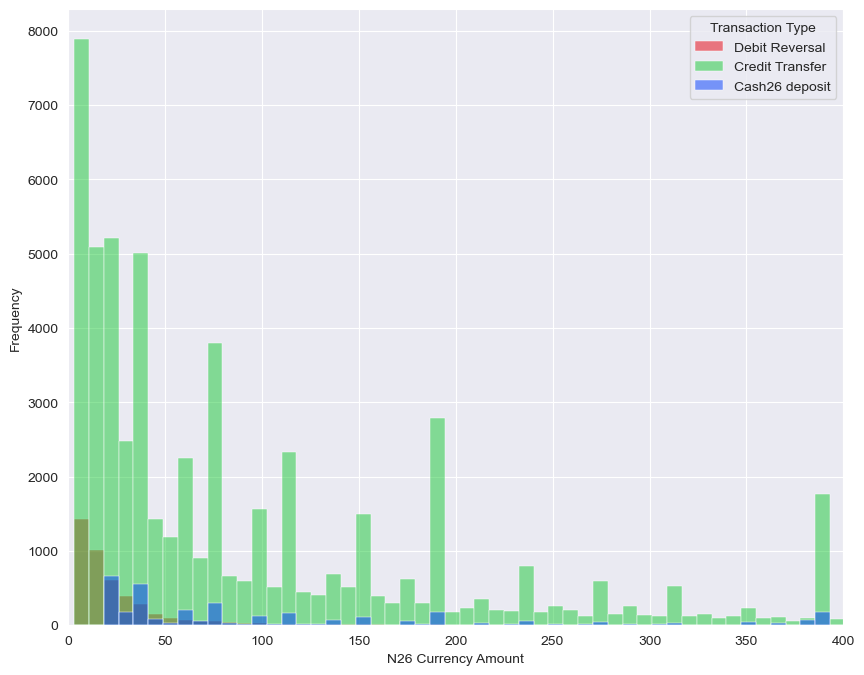

In [223]:
# looking at distribution of income data
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data[data['direction']=='In'],x='amount_n26_currency', hue=data['trans_type'],ax=ax, palette='bright')
ax.set(xlim=(0, 400))
plt.xlabel("N26 Currency Amount")
plt.ylabel("Frequency")
plt.legend(title='Transaction Type', loc='upper right', labels=['Debit Reversal','Credit Transfer','Cash26 deposit',])
plt.show()

### This is an important bit of information, basically income is almost all via credit transfers, hence i will likely just forcast income for august as a whole, doesn't make much sense to split the forecast

In [224]:
# looking at breakdown of transaction type for expenditure 
(data[data['direction']=='Out']
    .groupby('trans_type')
    .agg({'amount_n26_currency':['count','sum']})
    .sort_values(by=('amount_n26_currency','count'),ascending=False)
)

amount_n26_currency         
                                       count      sum
trans_type                                           
Presentment                           251591  6416168
Debit Transfer                         39530  3588003
Direct Debit                           29063   890367
MoneyBeam Transfer                      6316   249287
Cash26 withdrawal                        926    31865
Transferwise Transaction                 228    41737
Cash26 deposit                             0        0
Credit Transfer                            0        0
Debit Reversal                             0        0

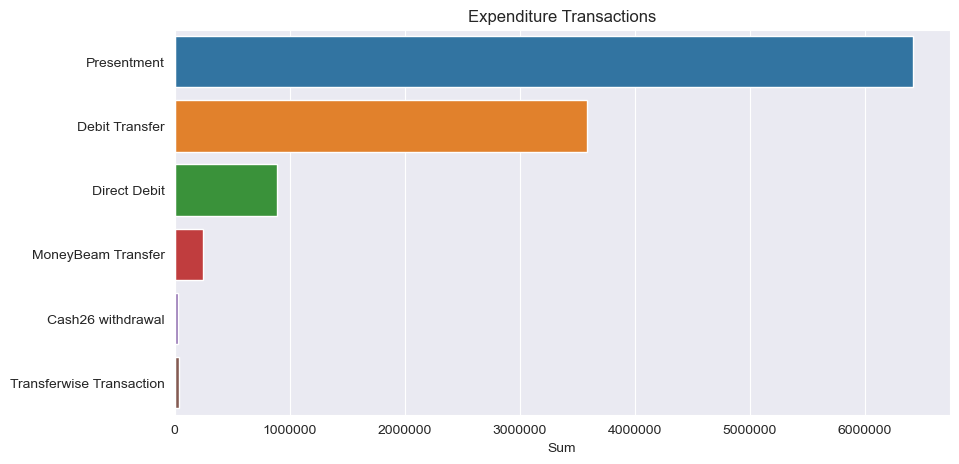

In [366]:
# plotting expenditure data on bar
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=data[data['direction']=='Out'], 
            y='trans_type',
            x='amount_n26_currency',
            ax=ax, 
            # palette='bright',
            estimator='sum',
            errorbar=None,
            order=['Presentment', 'Debit Transfer', 'Direct Debit','MoneyBeam Transfer', 'Cash26 withdrawal','Transferwise Transaction']
            )
plt.xlabel("Sum")
plt.ylabel("")
plt.title("Expenditure Transactions")
plt.ticklabel_format(style='plain', axis='x')
plt.show()

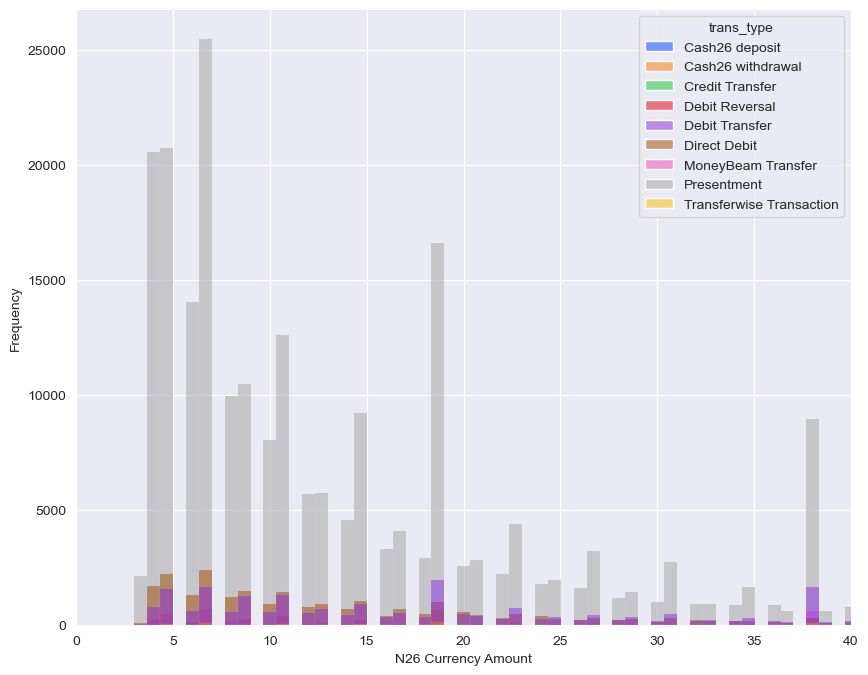

In [226]:
# plotting expenditure distribution
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data[data['direction']=='Out'],x='amount_n26_currency', hue=data['trans_type'],ax=ax, palette='bright')
ax.set(xlim=(0, 40))
plt.xlabel("N26 Currency Amount")
plt.ylabel("Frequency")
plt.show()

In [227]:
# having a look at master card expenditure breakdown
(data.groupby('mcc_group')
    .agg({'amount_n26_currency':['count','sum']})
    .sort_values(by=('amount_n26_currency','count'),ascending=False)
)

amount_n26_currency         
                                         count      sum
mcc_group                                              
ATM                                      67027  2876563
Groceries                                50185   554242
Travel/Hotel                             23095   686047
Gastronomie                              20459   250247
Automotive/Gas                           20404   330780
Shopping/(Fashion)                       20010   498038
Business Expenses                        11304   348974
Miscellaneous                            10860   251005
Transport                                10491   234905
Entertainment/Leisure                     7096   101789
Drugstore                                 5784    77425
Home and DIY, House Energy                3325   117351
Finance                                    785    58475
Education                                  321    18388
Family/Babies/Children                     285     6541
Insurance                                  137     4729
Taxes and Fines                             23      669

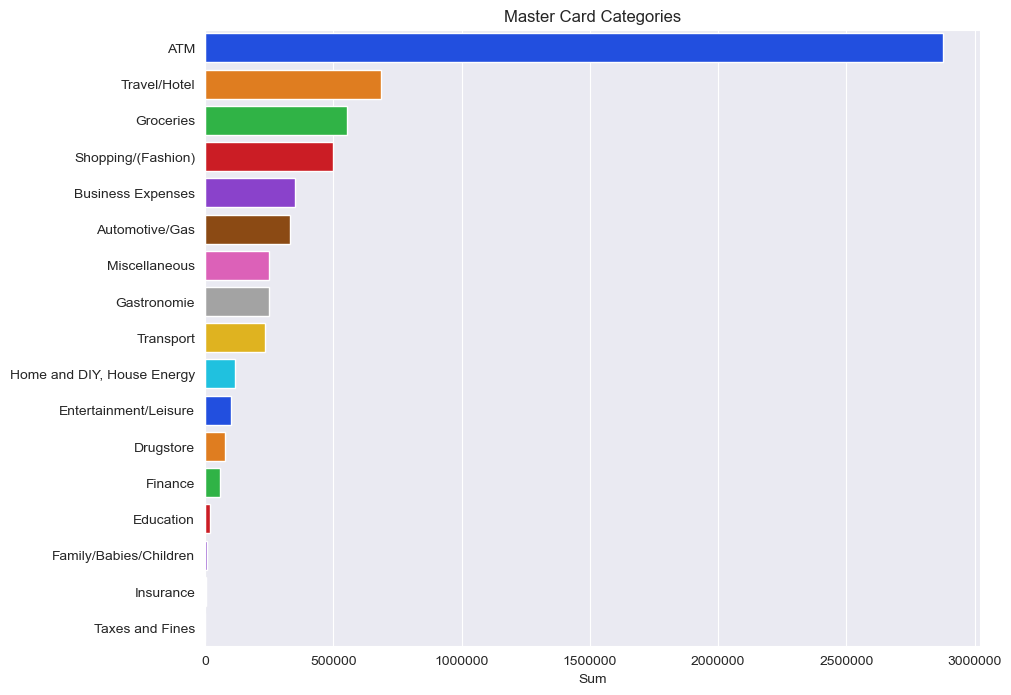

In [368]:
# plotting bar of mcc group
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=data[(data['direction']=='Out') & (data['agent'] == 'Card')], 
            y='mcc_group',
            x='amount_n26_currency',
            ax=ax, 
            palette='bright',
            estimator='sum',
            errorbar=None,
            order=data.groupby('mcc_group').sum(numeric_only=True).sort_values(by='amount_n26_currency',ascending=False).index
            )
plt.xlabel("Sum")
plt.ylabel("")
plt.ticklabel_format(style='plain', axis='x')
plt.title('Master Card Categories')
plt.show()

/opt/anaconda3/envs/n26/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


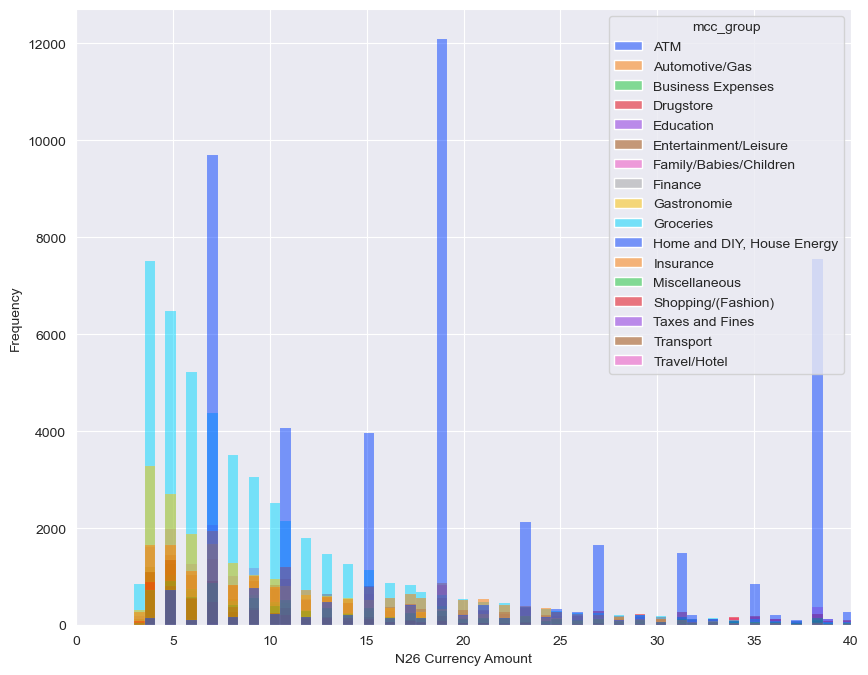

In [229]:
# plotting distribution  of mcc group distribution
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data[(data['direction']=='Out') & (data['agent'] == 'Card')],x='amount_n26_currency', hue=data['mcc_group'],ax=ax, palette='bright')
ax.set(xlim=(0, 40))
plt.xlabel("N26 Currency Amount")
plt.ylabel("Frequency")
plt.show()

In [230]:
# since atm withdrawals are not nice round figures just wanted to have a quick look at some of them
data[data['mcc_group'] == 'ATM'].head(10)

,user_id,transaction_date,amount_n26_currency,mcc_group,trans_type,direction,agent,month
2569,bfce3627883a60866ddb715cbc89a4a4,2016-02-02,5,ATM,Presentment,Out,Card,February
2570,cb972648b70a45d91c2df5f8c50ddf5e,2016-02-02,5,ATM,Presentment,Out,Card,February
2571,cb972648b70a45d91c2df5f8c50ddf5e,2016-02-02,112,ATM,Presentment,Out,Card,February
2572,d61ac9cb7961be09bcb30da690c28bad,2016-02-02,19,ATM,Presentment,Out,Card,February
2574,04a062b0b2c0323037706f4895855a8d,2016-02-02,23,ATM,Presentment,Out,Card,February
2575,3be760325b65f3bbe0d539fc1691f3e9,2016-02-02,38,ATM,Presentment,Out,Card,February
2576,3be760325b65f3bbe0d539fc1691f3e9,2016-02-02,27,ATM,Presentment,Out,Card,February
2577,5e0991078d5a5ef7fe8eba3cba1a9513,2016-02-02,15,ATM,Presentment,Out,Card,February
2578,91fbbfb8e4e5cb0bc110a71bb37cee35,2016-02-02,58,ATM,Presentment,Out,Card,February
2579,9c98e2ce1101531c1df26855d6fc1caa,2016-02-02,389,ATM,Presentment,Out,Card,February


### Before I go into modelling I want to build some time series plots of some of the categories, in order to see if I can find patterns, this will inform my decision on how i will model expenditure

In [231]:
data['trans_type'].unique()

['Debit Transfer', 'Credit Transfer', 'Debit Reversal', 'MoneyBeam Transfer', 'Direct Debit', 'Presentment', 'Cash26 deposit', 'Cash26 withdrawal', 'Transferwise Transaction']
Categories (9, object): ['Cash26 deposit', 'Cash26 withdrawal', 'Credit Transfer', 'Debit Reversal', ..., 'Direct Debit', 'MoneyBeam Transfer', 'Presentment', 'Transferwise Transaction']

<AxesSubplot: xlabel='transaction_date'>

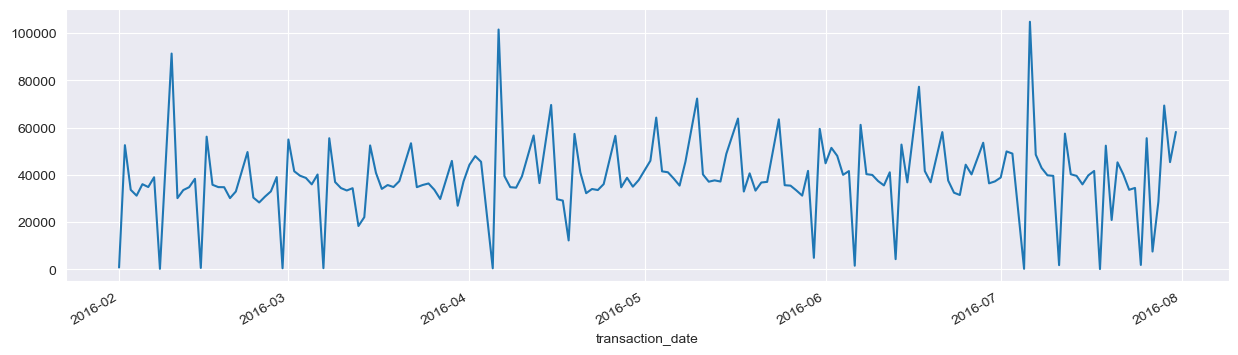

In [232]:
(data[data['trans_type']=='Presentment']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency']
    .plot(figsize=(15,4)))

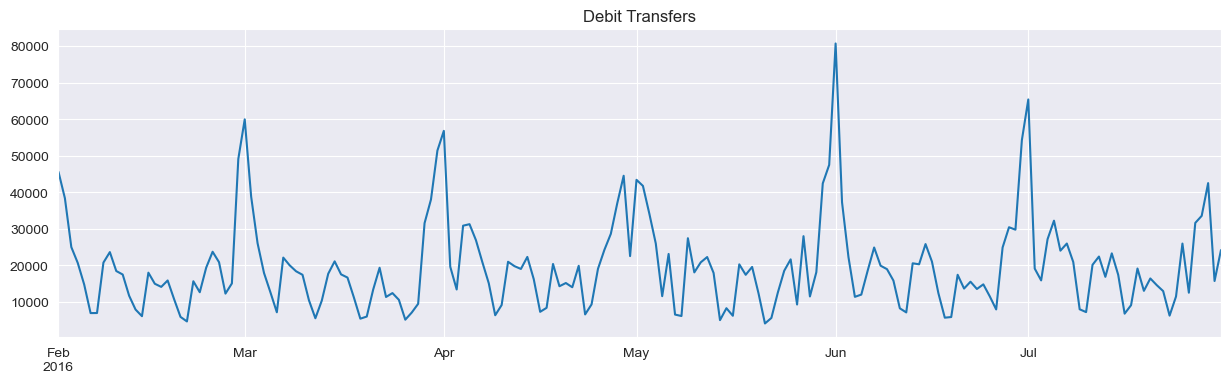

In [370]:
(data[data['trans_type']=='Debit Transfer']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency']
    .plot(figsize=(15,4)))
plt.title('Debit Transfers')
plt.xlabel('')
plt.show()

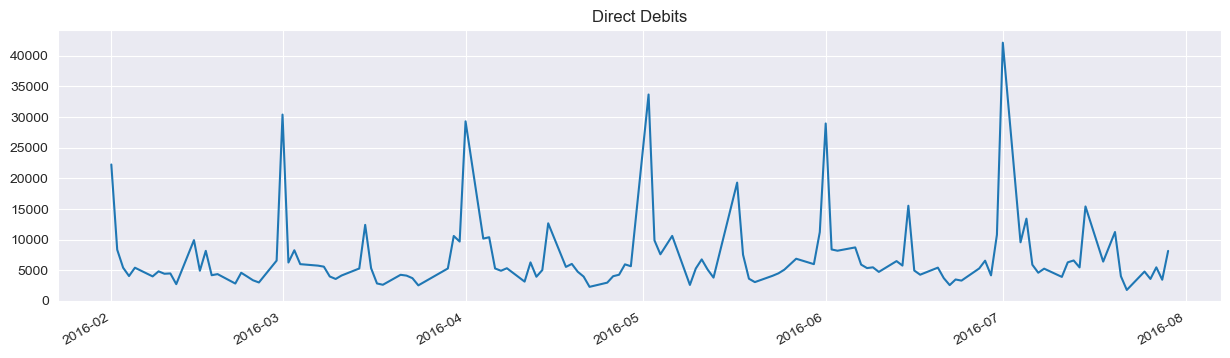

In [371]:
(data[data['trans_type']=='Direct Debit']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency']
    .plot(figsize=(15,4)))
plt.title('Direct Debits')
plt.xlabel('')
plt.show()

<AxesSubplot: xlabel='transaction_date'>

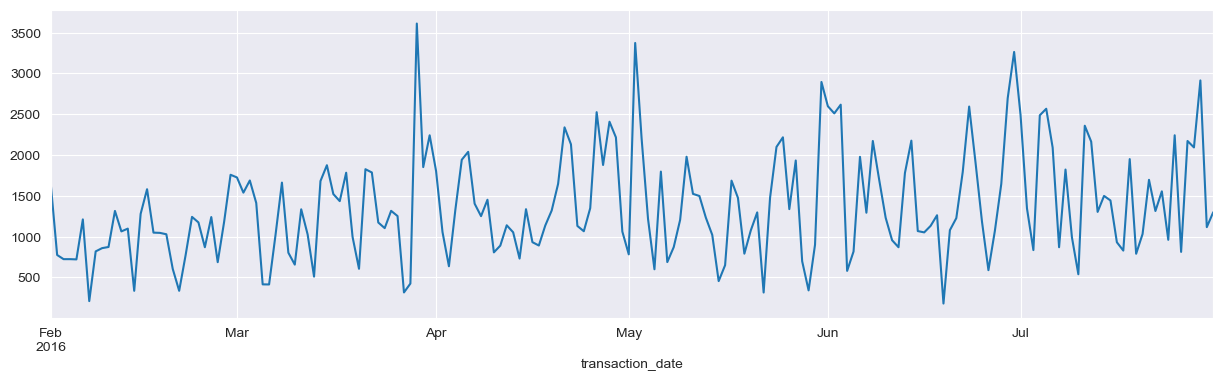

In [235]:
(data[data['trans_type']=='MoneyBeam Transfer']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency']
    .plot(figsize=(15,4)))

### for expenditure, based on the charts I think it makes sense to model debit transfers and direct debits seperatly, will investigate whether it is worth breaking down the presentment type further 

<AxesSubplot: xlabel='transaction_date'>

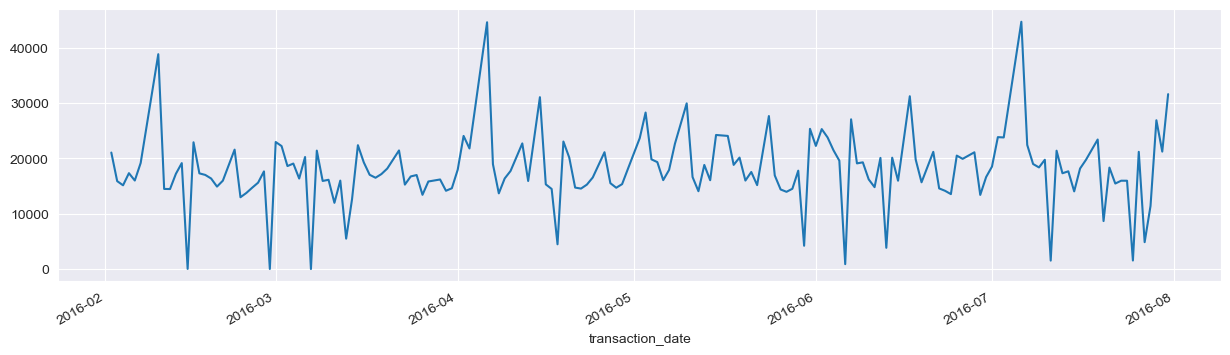

In [237]:
(data[data['mcc_group']=='ATM']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency']
    .plot(figsize=(15,4)))

<AxesSubplot: xlabel='transaction_date'>

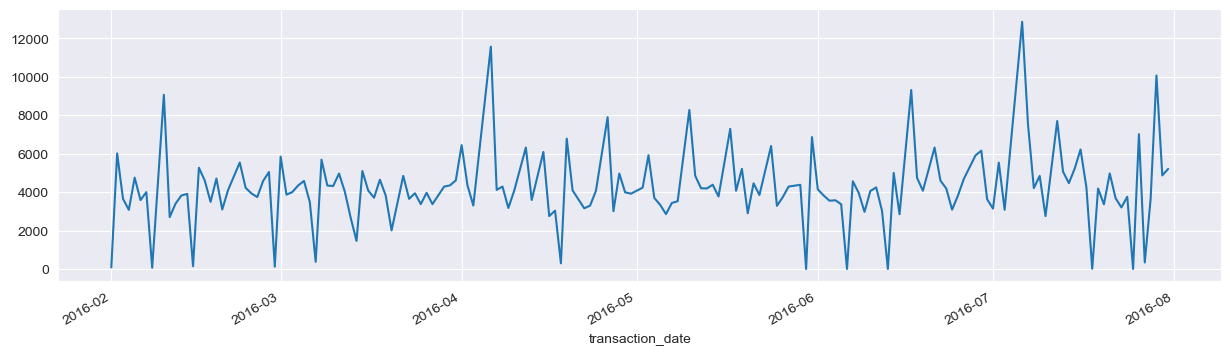

In [238]:
(data[data['mcc_group']=='Travel/Hotel']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency']
    .plot(figsize=(15,4)))

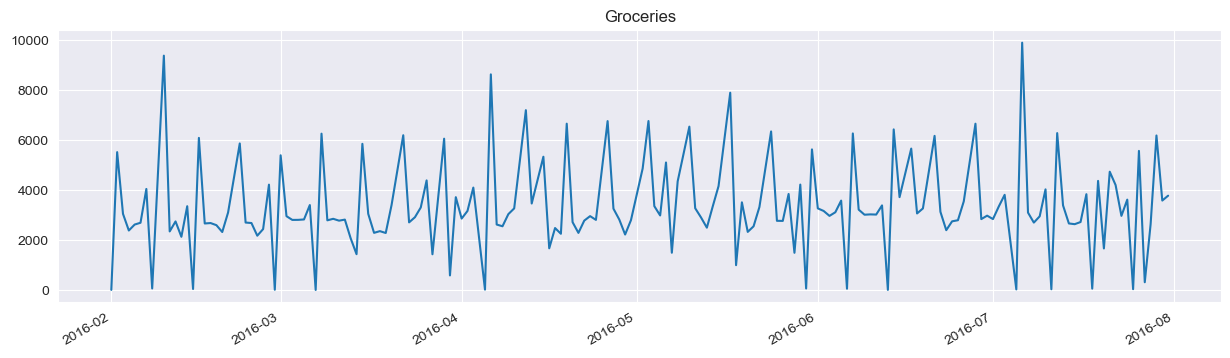

In [373]:
(data[data['mcc_group']=='Groceries']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency']
    .plot(figsize=(15,4)))
plt.title('Groceries')
plt.xlabel('')
plt.show()

<AxesSubplot: xlabel='transaction_date'>

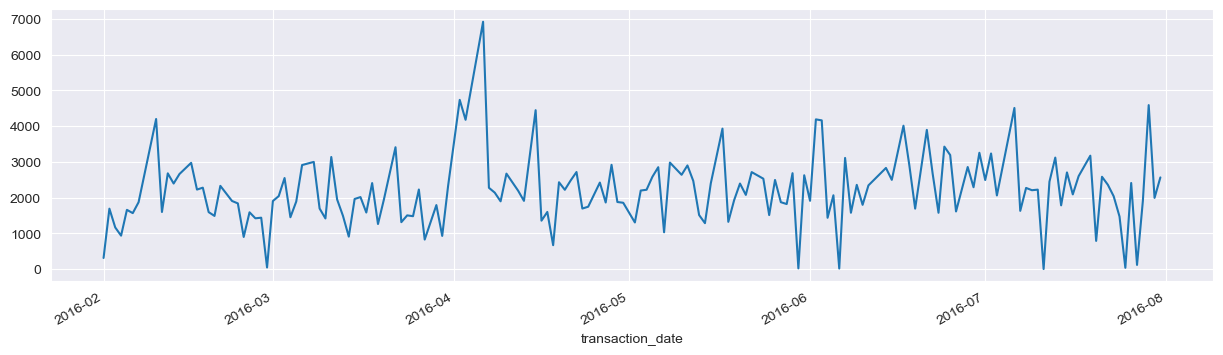

In [240]:
(data[data['mcc_group']=='Business Expenses']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency']
    .plot(figsize=(15,4)))

<AxesSubplot: xlabel='transaction_date'>

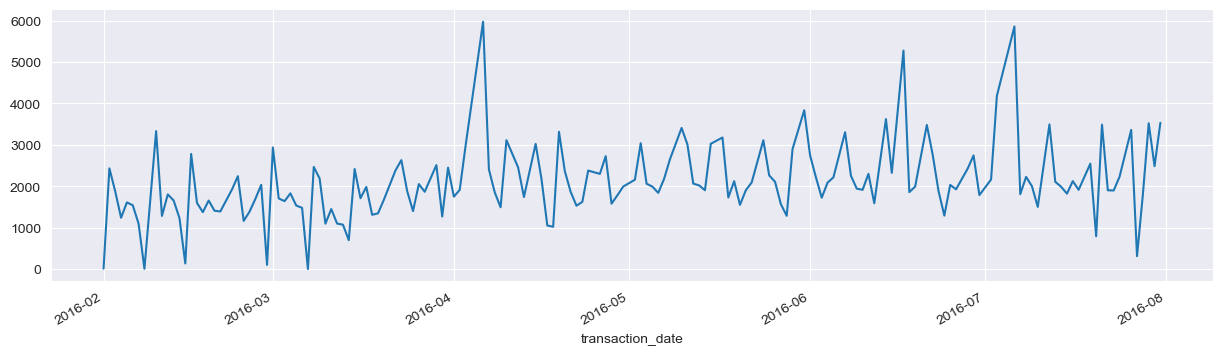

In [241]:
(data[data['mcc_group']=='Automotive/Gas']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency']
    .plot(figsize=(15,4)))

<AxesSubplot: xlabel='transaction_date'>

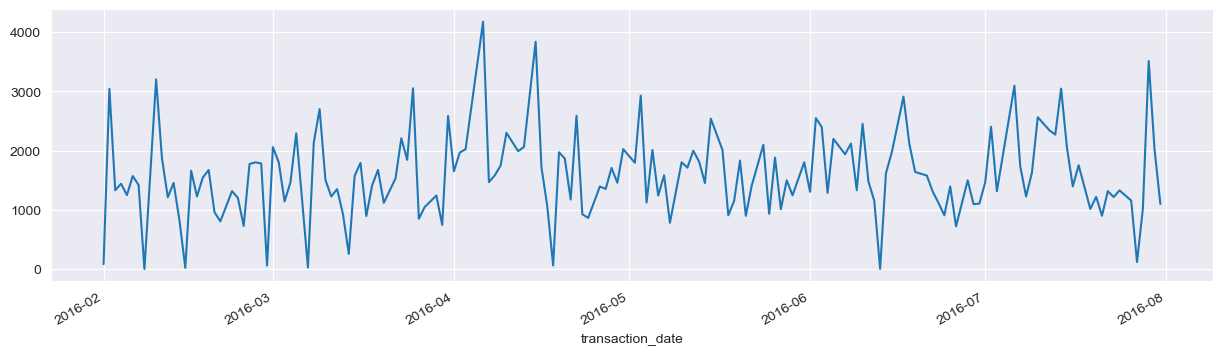

In [242]:
(data[data['mcc_group']=='Miscellaneous']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency']
    .plot(figsize=(15,4)))

<AxesSubplot: xlabel='transaction_date'>

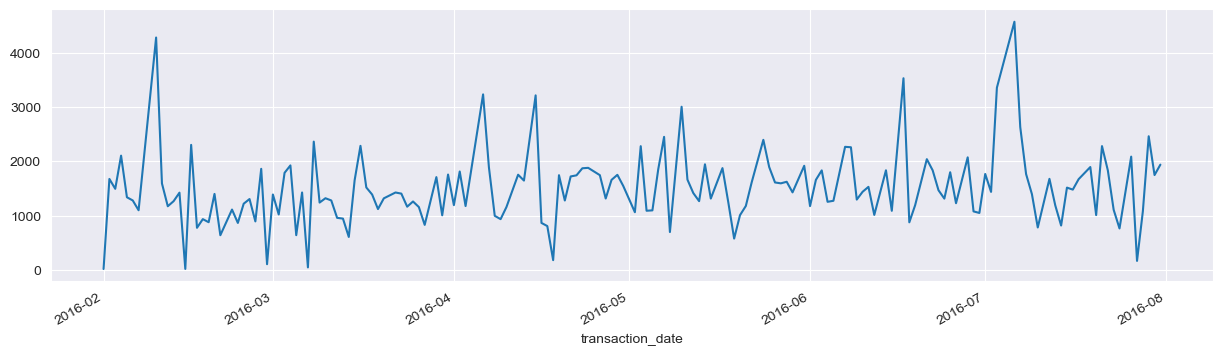

In [243]:
(data[data['mcc_group']=='Transport']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency']
    .plot(figsize=(15,4)))

### With the exception of groceries i can't really see the usefulness of splitting presentment down further, i think there is a clear path forward for modelling, income done as a whole and expenditure done in four groups, debit transfers, direct debits, groceries, everything else 

# 3. Time Series Forecasting
### The next step after exploratory data analysis is to build my forecasting model, I have decided to build my model with data aggregated into incoming and outcoming flows, there were a couple of reasons for doing this some of which I alluded to above 

### - For income this was a particularly easy deicion, since mcc categories are irrelevant, the only potential split would be on transaction types however since almost all income is in the form of credit transfer, it is nonsensical to do this

### - For outgoings there is potentially more reason to consider splitting my forecast, I have decided to split the forecast for expenditure as outlined above. 

### I would like to note here that I do think these category columns are extremely useful bits of data, particularly if we are interested in the behaviour of our customers and want to seperate different types of users. For this reason if I have time I will add a clustering section to show what else can be done with this data. 

In [244]:
# first i start with income
income = data[data['direction']=='In'].copy()
income = income.groupby('transaction_date').sum(numeric_only=True)
income.index.freq = 'd'


In [245]:
print('Augmented Dickey-Fuller Test on Income')
test = adfuller(income['amount_n26_currency'],autolag='AIC')
output = pd.Series(test[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in test[4].items():
    output[f'critical value ({key})']=val
print(output)

Augmented Dickey-Fuller Test on Income
ADF test statistic       -3.916098
p-value                   0.001920
# lags used              14.000000
# observations          167.000000
critical value (1%)      -3.470126
critical value (5%)      -2.879008
critical value (10%)     -2.576083
dtype: float64


### we can see that the pvalue from the ADF is below 0.05, i.e. no unit root detected and we fail to reject the null hypothesis. Since the ADF is best used for detecting long term trends in our data and given that visually we cannot see a trend of this sort we can with a reasonable degree of confidence say that our time series is stationary in this dimension. However to reiterate, visually I believe we can see seasnality and want to note the ADF does not rule this out. 

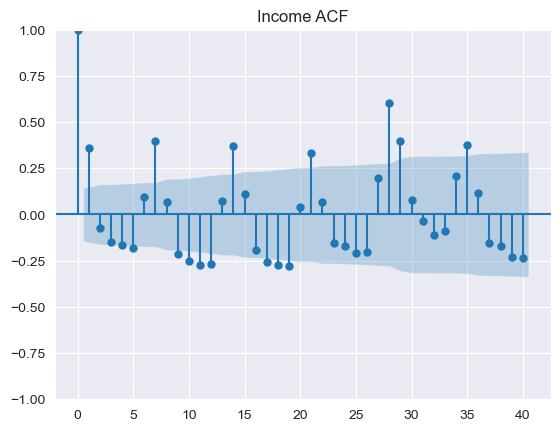

In [246]:
plot_acf(income['amount_n26_currency'],title='Income ACF',lags=40);

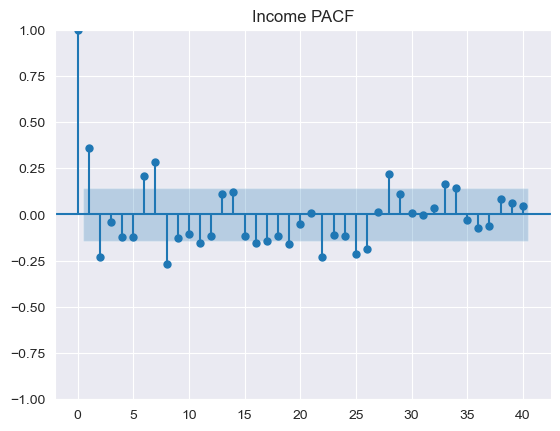

In [247]:
plot_pacf(income['amount_n26_currency'],title='Income PACF',lags=40, method='ywm');

### the plots support the evidence suggesting a seasonal component to the time series, it looks like there is a 7 day cyle to the data, there appears to be statistically signigicant correlation at 7,14,21 etc day intervals

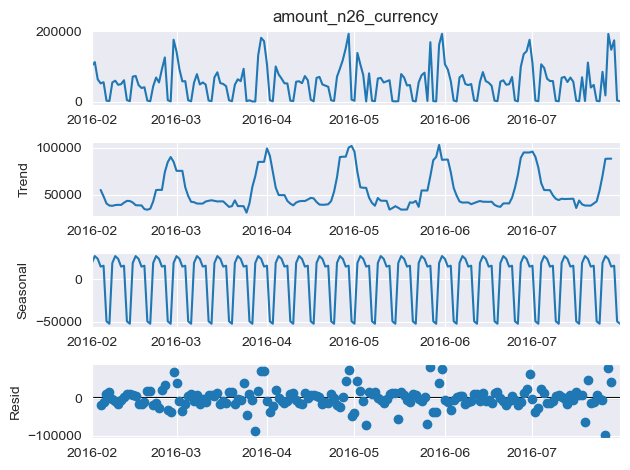

In [376]:
# performing ETS decomposition on income
seasonal_decompose(income['amount_n26_currency'],model='add').plot();


### Again the ETS decompoistion clear shows seasonality in the data, now we can move on to actually building out the model, note that the decompositions shows the monthly spike in the trend chart and the weekly cycle in the seasonal chart

In [249]:
# I use autoarima to do a grid search and find the best model, note that we use AIC which penalises increased complexity as the evaluation metric
stepwise_fit_income = (auto_arima(income['amount_n26_currency'],
                                 start_p=0,
                                 start_q=0,
                                 max_p=4,
                                 max_q=4,
                                 seasonal=True,
                                #  trace=True,
                                 m=7))
stepwise_fit_income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  182
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 7)   Log Likelihood               -2185.253
Date:                           Wed, 22 Feb 2023   AIC                           4382.506
Time:                                   12:39:29   BIC                           4401.730
Sample:                                        0   HQIC                          4390.299
                                           - 182                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.792e+04   1.89e+04      2.536      0.011    1.09e+04     8.5e+04
ma.L1          0.3951      0.070      5.643      0.000       0.258       0.532
ar.S.L7       -0.2121      0.319     -0.665      0.506      -0.837       0.413
ar.S.L14       0.4116      0.125      3.295      0.001       0.167       0.656
ma.S.L7        0.5917      0.324      1.825      0.068      -0.044       1.227
sigma2      1.962e+09      0.607   3.23e+09      0.000    1.96e+09    1.96e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                63.63
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             1.13
Prob(H) (two-sided):                  0.39   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.83e+24. Standard errors may be unstable.
"""

### auto arima reccomends a seasonal arima model

In [250]:
# creating train test splits
income_train = income.iloc[:151]
income_test = income.iloc[151:]

In [251]:
# creating models
income_model = (SARIMAX(income_train['amount_n26_currency'], 
                        order=(0, 0, 1),seasonal_order=(2, 0, 1, 7), 
                        enforce_invertibility=False)
                .fit(maxiter=100))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22020D+01    |proj g|=  4.52961D-01

At iterate    5    f=  1.21396D+01    |proj g|=  8.58325D-03

At iterate   10    f=  1.21334D+01    |proj g|=  1.38536D-02

At iterate   15    f=  1.21329D+01    |proj g|=  3.92339D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   1.391D-05   1.213D+01
  F =   12.132910143437041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [252]:
# income model summary
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:               amount_n26_currency   No. Observations:                  151
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 7)   Log Likelihood               -1832.069
Date:                           Wed, 22 Feb 2023   AIC                           3674.139
Time:                                   12:39:30   BIC                           3689.225
Sample:                               02-01-2016   HQIC                          3680.268
                                    - 06-30-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4767      0.178      2.675      0.007       0.127       0.826
ar.S.L7        0.9116      0.463      1.969      0.049       0.004       1.819
ar.S.L14       0.0666      0.407      0.164      0.870      -0.732       0.865
ma.S.L7       -0.8131      0.398     -2.042      0.041      -1.594      -0.033
sigma2      3.798e+09   3.81e-11   9.96e+19      0.000     3.8e+09     3.8e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                55.54
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                             0.94
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.8e+36. Standard errors may be unstable.
"""

In [253]:
# need to create start and end range for predictions 
start = len(income_train)
end = len(income_train) + len(income_test) - 1

In [254]:
# creating predictions
income_predictions = income_model.predict(start,end,typ='levels').rename('SARIMA Predictions')
income_test['SARIMA_predictions'] = income_predictions

/var/folders/jk/7_97xl9d43v9l_jqg7kbpf9m0000gn/T/ipykernel_5982/3061951235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_test['SARIMA_predictions'] = income_predictions


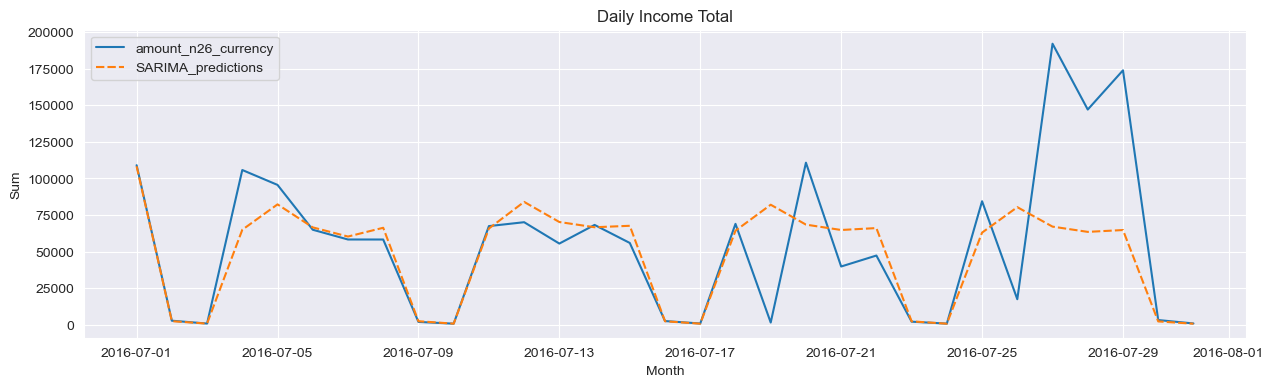

In [255]:
#plotting results
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=income_test, 
            ax=ax, 
            estimator='count',
            )
plt.xlabel("Month")
plt.ylabel("Sum")
plt.title('Daily Income Total')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [256]:
# metrics for income model
print('root mean squared error')
print(rmse(income_test['amount_n26_currency'],income_test['SARIMA_predictions']))
print('-----------------------------')
print('mean absolute error')
print(meanabs(income_test['amount_n26_currency'],income_test['SARIMA_predictions']))

root mean squared error
40416.721368431026
-----------------------------
mean absolute error
22118.878809015103


### The models look reasonably ok, however for it isnt accounting for spikes that typically occur towards the end and beginning of the months, therefore I think we can improve the model by including exogenous x variables 

In [257]:
# creating a daily flow table, as I am using VS Code I will use the variable explorer
# to see where to create my exogenous x variables
daily_flow = data.pivot_table(index='transaction_date',values='amount_n26_currency',columns='direction',aggfunc='sum')

In [258]:
# need to get first two and last two business days of month for income fyis susp_paydays is short for suspected pay days 
business_days_df = pd.DataFrame(pd.bdate_range('2016-01-01', '2016-12-31'), columns=['business_days'])
business_days_df['month'] = business_days_df['business_days'].dt.month_name()
first_two_bd = business_days_df.groupby('month').head(2)
last_two_bd = business_days_df.groupby('month').tail(2)
susp_paydays = (pd.concat(objs=[first_two_bd,last_two_bd],ignore_index=True)
    .sort_values(by='business_days'))

In [259]:
# now I can reshape the income data and rerun the model with these dates as x variables 
income = data[data['direction']=='In'].copy()
income = income.groupby('transaction_date').sum(numeric_only=True)
income.index.freq = 'd'
income['pay_days'] = np.where(pd.Series(income.index).isin(susp_paydays['business_days']),1,0)

In [260]:
# creating train test splits
income_train = income.iloc[:151]
income_test = income.iloc[151:]

In [261]:
stepwise_fit_income = auto_arima(income['amount_n26_currency'],
                                 exogenous=income[['pay_days']],
                                 start_p=0,
                                 start_q=0,
                                 max_p=4,
                                 max_q=4,
                                 seasonal=True,
                                #  trace=True,
                                 m=7)
stepwise_fit_income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  182
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 7)   Log Likelihood               -2163.757
Date:                           Wed, 22 Feb 2023   AIC                           4341.514
Time:                                   12:39:35   BIC                           4363.942
Sample:                               02-01-2016   HQIC                          4350.606
                                    - 07-31-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.528e+04   1.82e+04      1.942      0.052    -335.206    7.09e+04
pay_days    1.374e+05   6846.458     20.070      0.000    1.24e+05    1.51e+05
ma.L1          0.1039      0.085      1.228      0.219      -0.062       0.270
ar.S.L7       -0.2676      0.547     -0.489      0.625      -1.340       0.805
ar.S.L14       0.3444      0.219      1.574      0.116      -0.085       0.773
ma.S.L7        0.6618      0.574      1.153      0.249      -0.463       1.786
sigma2      1.454e+09      0.340   4.27e+09      0.000    1.45e+09    1.45e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                25.76
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             0.41
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.48e+24. Standard errors may be unstable.
"""

In [262]:
# creating models
income_model = (SARIMAX(income_train['amount_n26_currency'],
                        exog=income_train[['pay_days']],
                        order=(0, 0, 1),seasonal_order=(2, 0, 1, 7), 
                        enforce_invertibility=False)
                .fit(maxiter=100))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19865D+01    |proj g|=  2.20924D-01

At iterate    5    f=  1.19526D+01    |proj g|=  4.32434D-03

At iterate   10    f=  1.19498D+01    |proj g|=  6.28418D-03

At iterate   15    f=  1.19497D+01    |proj g|=  2.56154D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     18      1     0     0   2.562D-05   1.195D+01
  F =   11.949671551082719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [263]:
# printing summary
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:               amount_n26_currency   No. Observations:                  151
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 7)   Log Likelihood               -1804.400
Date:                           Wed, 22 Feb 2023   AIC                           3620.801
Time:                                   12:39:36   BIC                           3638.904
Sample:                               02-01-2016   HQIC                          3628.155
                                    - 06-30-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pay_days    1.381e+05   1.33e+04     10.390      0.000    1.12e+05    1.64e+05
ma.L1          0.1728      0.164      1.053      0.292      -0.149       0.494
ar.S.L7        1.0793      0.353      3.058      0.002       0.388       1.771
ar.S.L14      -0.1073      0.297     -0.361      0.718      -0.690       0.476
ma.S.L7       -0.7947      0.306     -2.596      0.009      -1.395      -0.195
sigma2      2.345e+09      0.143   1.64e+10      0.000    2.34e+09    2.34e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                36.14
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.13
Prob(H) (two-sided):                  0.45   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.18e+25. Standard errors may be unstable.
"""

In [264]:
# creating predictions
income_predictions = income_model.predict(start,end,typ='levels',exog=income_test[['pay_days']]).rename('SARIMA Predictions')
income_test['SARIMA_predictions'] = income_predictions

/var/folders/jk/7_97xl9d43v9l_jqg7kbpf9m0000gn/T/ipykernel_5982/798950846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_test['SARIMA_predictions'] = income_predictions


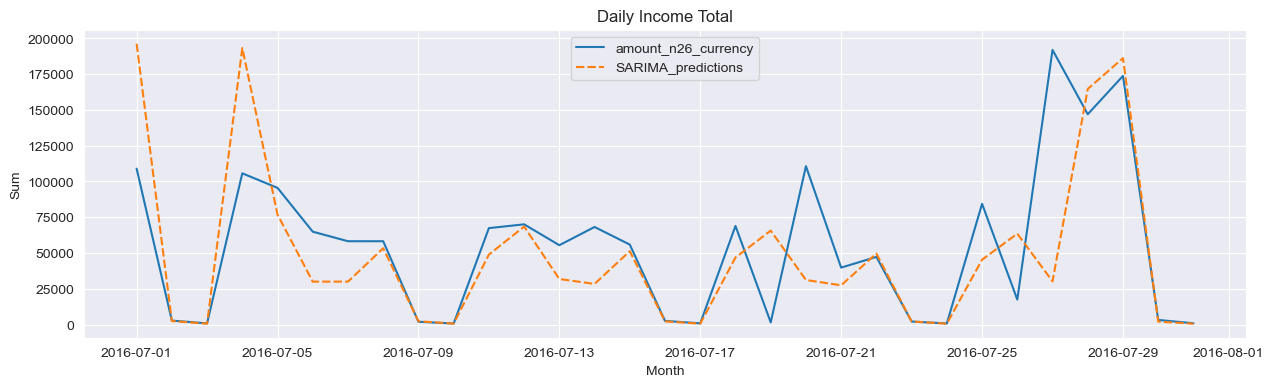

In [265]:
#plotting results
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=income_test[['amount_n26_currency','SARIMA_predictions']], 
            ax=ax, 
            estimator='count',
            )
plt.xlabel("Month")
plt.ylabel("Sum")
plt.title('Daily Income Total')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [266]:
# metrics for income model
print('root mean squared error')
print(rmse(income_test['amount_n26_currency'],income_test['SARIMA_predictions']))
print('-----------------------------')
print('mean absolute error')
print(meanabs(income_test['amount_n26_currency'],income_test['SARIMA_predictions']))

root mean squared error
44560.73312665384
-----------------------------
mean absolute error
26139.37255687878


### the model is hitting the spike at the end but is over forecasting, I think this is because of the way I have put the four days into my model, will try again but enter them as seperate columns 

In [267]:
# need to get first two and last two business days of month for income fyis susp_paydays is short for suspected pay days 
business_days_df = pd.DataFrame(pd.bdate_range('2016-01-01', '2016-12-31'), columns=['business_days'])
business_days_df['month'] = business_days_df['business_days'].dt.month_name()
first_two_bd = business_days_df.groupby('month').head(2)
last_two_bd = business_days_df.groupby('month').tail(2)
susp_paydays = (pd.concat(objs=[first_two_bd,last_two_bd],ignore_index=True)
    .sort_values(by='business_days'))

In [268]:
# creating dummy variables for each pay day
susp_paydays['pay_day_num'] = susp_paydays.groupby('month')['business_days'].rank().astype('category')
susp_paydays = susp_paydays.drop('month',axis=1)
susp_paydays = pd.get_dummies(susp_paydays)

In [269]:
# now I can reshape the income data and rerun the model with these dates as x variables 
income = data[data['direction']=='In'].copy()
income = income.groupby('transaction_date').sum(numeric_only=True)
income.index.freq = 'd'

In [270]:
# merging dummies to data
income = income.merge(susp_paydays, how='left',left_index=True, right_on='business_days')
income = income.fillna(0)
income = income.rename(columns={'business_days':'date'})
income = income.set_index('date')
income.index.freq='d'

In [271]:
# creating train test splits
income_train = income.iloc[:151]
income_test = income.iloc[151:]

In [272]:
stepwise_fit_income = auto_arima(income['amount_n26_currency'],
                                 exogenous=income[['pay_day_num_1.0','pay_day_num_2.0','pay_day_num_3.0','pay_day_num_4.0']],
                                 start_p=0,
                                 start_q=0,
                                 max_p=4,
                                 max_q=4,
                                 seasonal=True,
                                #  trace=True,
                                 m=7)
stepwise_fit_income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  182
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 7)   Log Likelihood               -2153.526
Date:                           Wed, 22 Feb 2023   AIC                           4327.053
Time:                                   12:39:43   BIC                           4359.093
Sample:                               02-01-2016   HQIC                          4340.041
                                    - 07-31-2016                                         
Covariance Type:                             opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept        3.454e+04   2.14e+04      1.615      0.106   -7378.172    7.65e+04
pay_day_num_1.0  1.171e+05   1.29e+04      9.094      0.000    9.19e+04    1.42e+05
pay_day_num_2.0  1.009e+05   1.39e+04      7.254      0.000    7.36e+04    1.28e+05
pay_day_num_3.0  1.516e+05   1.22e+04     12.388      0.000    1.28e+05    1.76e+05
pay_day_num_4.0  1.801e+05   1.27e+04     14.178      0.000    1.55e+05    2.05e+05
ma.L1               0.1263      0.094      1.350      0.177      -0.057       0.310
ar.S.L7            -0.2722      0.699     -0.390      0.697      -1.641       1.097
ar.S.L14            0.3681      0.290      1.267      0.205      -0.201       0.937
ma.S.L7             0.6987      0.737      0.948      0.343      -0.746       2.143
sigma2           1.342e+09      0.682   1.97e+09      0.000    1.34e+09    1.34e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                44.04
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.81
Prob(H) (two-sided):                  0.17   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.97e+22. Standard errors may be unstable.
"""

In [273]:
# creating models
income_model = (SARIMAX(income_train['amount_n26_currency'],
                        exog=income_train[['pay_day_num_1.0','pay_day_num_2.0','pay_day_num_3.0','pay_day_num_4.0']],
                        order=(0, 0, 1),seasonal_order=(2, 0, 1, 7), 
                        enforce_invertibility=False)
                .fit(maxiter=100))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19405D+01    |proj g|=  2.47652D-01

At iterate    5    f=  1.18975D+01    |proj g|=  2.54329D-03

At iterate   10    f=  1.18974D+01    |proj g|=  7.77409D-04

At iterate   15    f=  1.18971D+01    |proj g|=  1.10016D-02

At iterate   20    f=  1.18970D+01    |proj g|=  4.01429D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     22     27      1     0     0   1.269D-05   1.190D+01
  F =   11.897024920175994     

CONVERG

In [274]:
# income model summary
income_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:               amount_n26_currency   No. Observations:                  151
Model:             SARIMAX(0, 0, 1)x(2, 0, 1, 7)   Log Likelihood               -1796.451
Date:                           Wed, 22 Feb 2023   AIC                           3610.902
Time:                                   12:39:44   BIC                           3638.057
Sample:                               02-01-2016   HQIC                          3621.934
                                    - 06-30-2016                                         
Covariance Type:                             opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
pay_day_num_1.0  1.187e+05   2.65e+04      4.474      0.000    6.67e+04    1.71e+05
pay_day_num_2.0  9.993e+04   2.59e+04      3.859      0.000    4.92e+04    1.51e+05
pay_day_num_3.0  1.525e+05   2.23e+04      6.833      0.000    1.09e+05    1.96e+05
pay_day_num_4.0  1.814e+05   2.53e+04      7.166      0.000    1.32e+05    2.31e+05
ma.L1               0.1661      0.214      0.776      0.438      -0.253       0.586
ar.S.L7             1.0187      0.402      2.531      0.011       0.230       1.808
ar.S.L14           -0.0454      0.356     -0.127      0.899      -0.744       0.653
ma.S.L7            -0.7843      0.340     -2.309      0.021      -1.450      -0.119
sigma2           2.179e+09      0.402   5.42e+09      0.000    2.18e+09    2.18e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                40.29
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                             0.25
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.96e+23. Standard errors may be unstable.
"""

In [275]:
# creating predictions
income_predictions = (income_model.predict(start,end,typ='levels',exog=income_test[['pay_day_num_1.0',
                                                                                   'pay_day_num_2.0',
                                                                                   'pay_day_num_3.0',
                                                                                   'pay_day_num_4.0']])
                        .rename('SARIMA Predictions'))
income_test['SARIMA_predictions'] = income_predictions

/var/folders/jk/7_97xl9d43v9l_jqg7kbpf9m0000gn/T/ipykernel_5982/2081697452.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_test['SARIMA_predictions'] = income_predictions


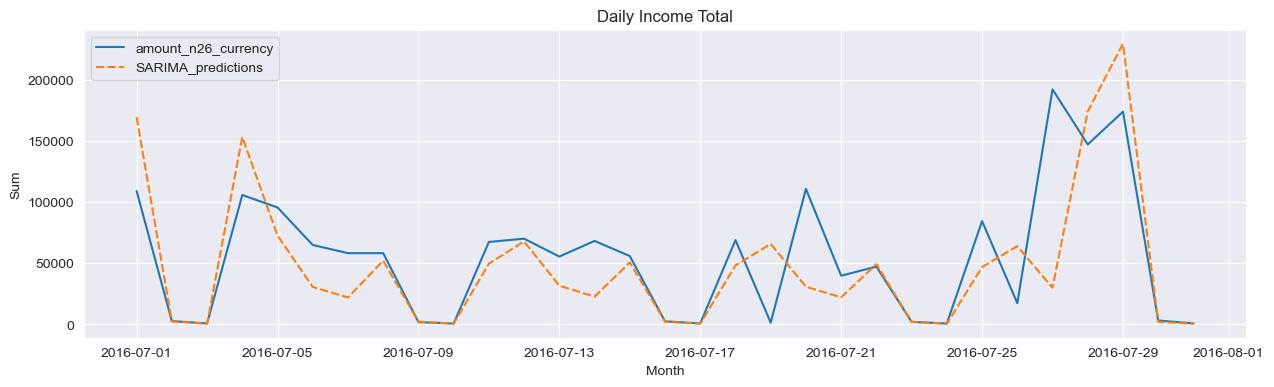

In [276]:
#plotting results
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=income_test[['amount_n26_currency','SARIMA_predictions']], 
            ax=ax, 
            estimator='count',
            )
plt.xlabel("Month")
plt.ylabel("Sum")
plt.title('Daily Income Total')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [277]:
# metrics for income model
print('root mean squared error')
print(rmse(income_test['amount_n26_currency'],income_test['SARIMA_predictions']))
print('-----------------------------')
print('mean absolute error')
print(meanabs(income_test['amount_n26_currency'],income_test['SARIMA_predictions']))

root mean squared error
42798.976454378484
-----------------------------
mean absolute error
26378.864028964923


### visually the final model looks slighly better, but according to rmse and mae it is slightly worse, i think the problem is that we simply dont have enough data points for the exogenous regressors to get them perfect, I am going to use model three because I think follows the shape of the data best, and i think the extra month in training will help it and i suspect in the real world it will be best

In [278]:
# creating final income model
final_income_model = (SARIMAX(income['amount_n26_currency'],
                        exog=income[['pay_day_num_1.0','pay_day_num_2.0','pay_day_num_3.0','pay_day_num_4.0']],
                        order=(0, 0, 1),seasonal_order=(2, 0, 1, 7), 
                        enforce_invertibility=False)
                .fit(maxiter=100))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19904D+01    |proj g|=  2.24005D-01

At iterate    5    f=  1.19497D+01    |proj g|=  1.93800D-03


 This problem is unconstrained.



At iterate   10    f=  1.19494D+01    |proj g|=  8.66697D-03

At iterate   15    f=  1.19490D+01    |proj g|=  1.41480D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     18     22      1     0     0   1.197D-05   1.195D+01
  F =   11.948988167386362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [279]:
# creating the august dataframe with the exogenous x variables
august_income_df = pd.DataFrame(pd.date_range('2016-08-01','2016-08-31',freq='D'),columns=['date'])
august_income_df = august_income_df.merge(susp_paydays, how='left',left_on='date', right_on='business_days')
august_income_df = august_income_df.fillna(0)
august_income_df = august_income_df.drop('business_days',axis=1)
august_income_df = august_income_df.set_index('date')
august_income_df.index.freq = 'd'

In [280]:
# need to recreate this as it is different form my train test split
start = len(income)
end = len(income) + len(august_income_df) - 1

In [281]:
# creating predictions
income_predictions = (final_income_model.predict(start,end,typ='levels',exog=august_income_df[['pay_day_num_1.0',
                                                                                   'pay_day_num_2.0',
                                                                                   'pay_day_num_3.0',
                                                                                   'pay_day_num_4.0']])
                        .rename('SARIMA Predictions'))
august_income_df['SARIMA_predictions'] = income_predictions

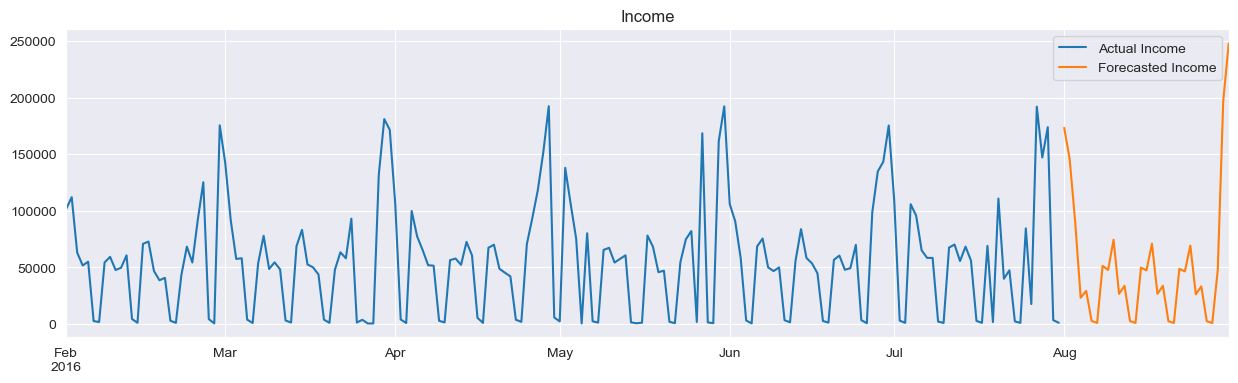

In [377]:
income['amount_n26_currency'].plot(figsize=(15,4),legend=True)
august_income_df['SARIMA_predictions'].plot(legend=True)
plt.legend(title=None, loc='upper right', labels=['Actual Income','Forecasted Income'])
plt.title('Income')
plt.xlabel('')
plt.show()

In [283]:
# saving output and model
august_income_df.to_csv('predictions/august_income_forecast.csv')

file = open('models/income_model.pkl', 'wb+')
pickle.dump(final_income_model, file)

### It isnt perfect I think that it looks like it might be overdoing the spike at the end of the month but given i think there is a slight underforecast earlier in the month looking at it visually the overall monthly forecast shoudnt be too far off. 

### next we move onto expenditure

In [284]:
# cutting the data
idx = pd.date_range('2016-02-01', '2016-07-31',freq='D')

expenditure_debit_transfers = (data[(data['direction']=='Out') & (data['trans_type']=='Debit Transfer')]
                                .copy()
                                .groupby('transaction_date')
                                .sum(numeric_only=True))
expenditure_debit_transfers = expenditure_debit_transfers.reindex(idx, fill_value=0)
expenditure_debit_transfers.index.freq='D'

expenditure_direct_debits = (data[(data['direction']=='Out') & (data['trans_type']=='Direct Debit')]
                                .copy()
                                .groupby('transaction_date')
                                .sum(numeric_only=True))
expenditure_direct_debits = expenditure_direct_debits.reindex(idx, fill_value=0)
expenditure_direct_debits.index.freq='D'

expenditure_groceries = (data[(data['direction']=='Out') & (data['mcc_group']=='Groceries')]
                                .copy()
                                .groupby('transaction_date')
                                .sum(numeric_only=True))
expenditure_groceries = expenditure_groceries.reindex(idx, fill_value=0)
expenditure_groceries.index.freq='D'

expenditure_misc = (data[(data['direction']=='Out') & (data['mcc_group']!='Groceries') & (data['trans_type']!='Debit Transfer') & (data['trans_type']!='Direct Debit')]
                                .copy()
                                .groupby('transaction_date')
                                .sum(numeric_only=True))
expenditure_misc = expenditure_misc.reindex(idx, fill_value=0)
expenditure_misc.index.freq='D'

### Starting with direct debits

In [285]:
print('Augmented Dickey-Fuller Test on Income')
test = adfuller(expenditure_direct_debits['amount_n26_currency'],autolag='AIC')
output = pd.Series(test[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in test[4].items():
    output[f'critical value ({key})']=val
print(output)

Augmented Dickey-Fuller Test on Income
ADF test statistic       -3.679064
p-value                   0.004417
# lags used              13.000000
# observations          168.000000
critical value (1%)      -3.469886
critical value (5%)      -2.878903
critical value (10%)     -2.576027
dtype: float64


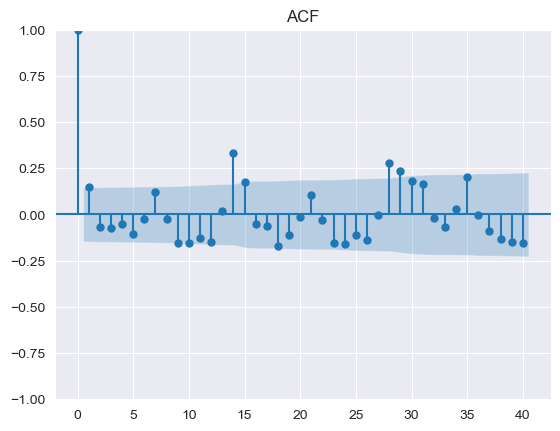

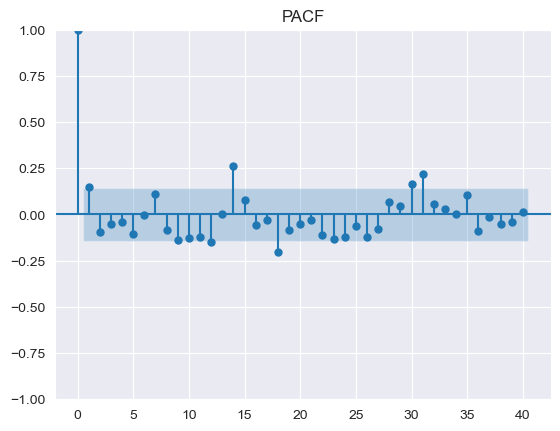

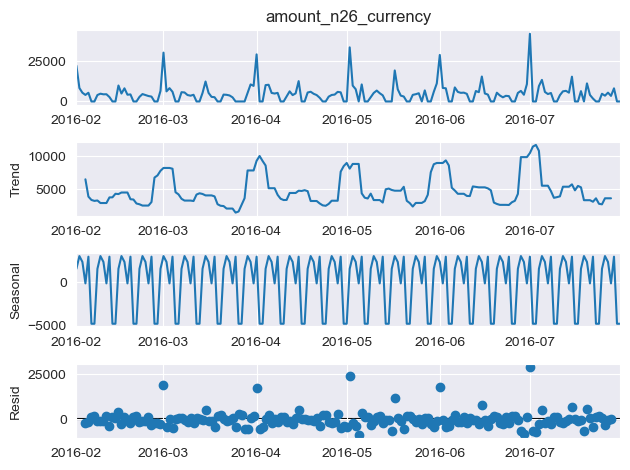

In [286]:
plot_acf(expenditure_direct_debits['amount_n26_currency'],title='ACF',lags=40);
plot_pacf(expenditure_direct_debits['amount_n26_currency'],title='PACF',lags=40, method='ywm');
seasonal_decompose(expenditure_direct_debits['amount_n26_currency'],model='add').plot();

In [287]:
# storing above object so i can use variable explorer
direct_debits =(data[data['trans_type']=='Direct Debit']
    .groupby('transaction_date')
    .sum(numeric_only=True)['amount_n26_currency'])

### its looks as though the spike occurs at the start of each month and in the middle on the 15th. The exception is May where the first spike is on the 2nd of may, this makes sense since the 1st is a sunday and in many countries May is public holiday. however the spike in the middle of the month is on the 17th rather than the 15th. I cant think why this might be since this is a tuesday. 

### In any case I think it doesnt matter, since there are only a few dates I can hardcode them into my training data and for august I can use the 1st and the 15th which are both mondays 

In [288]:
# hardcoding spike dates
dd_spike_1 = pd.to_datetime(['2016-02-01','2016-03-01','2016-04-01','2016-05-02','2016-06-01','2016-07-01','2016-08-01'])
dd_spike_2 = pd.to_datetime(['2016-02-15','2016-03-15','2016-04-15','2016-05-17','2016-06-15','2016-07-15','2016-08-15'])

In [289]:
# adding dd spike dates
expenditure_direct_debits['dd_spike_1'] = np.where(pd.Series(expenditure_direct_debits.index).isin(dd_spike_1),1,0)
expenditure_direct_debits['dd_spike_2'] = np.where(pd.Series(expenditure_direct_debits.index).isin(dd_spike_2),1,0)

In [290]:
# creating train test split
expenditure_dd_train = expenditure_direct_debits.iloc[:151]
expenditure_dd_test = expenditure_direct_debits.iloc[151:]

In [291]:
# I use autoarima to do a grid search and find the best model, note that we use AIC which penalises increased complexity as the evaluation metric
stepwise_fit_expenditure = auto_arima(expenditure_direct_debits['amount_n26_currency'],
                                 exogenous=expenditure_direct_debits[['dd_spike_1','dd_spike_2']],
                                 start_p=0,
                                 start_q=0,
                                 max_p=4,
                                 max_q=4,
                                 seasonal=True,
                                #  trace=True,
                                 m=7)
stepwise_fit_expenditure.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  182
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -1686.163
Date:                   Wed, 22 Feb 2023   AIC                           3382.326
Time:                           12:39:56   BIC                           3398.346
Sample:                       02-01-2016   HQIC                          3388.820
                            - 07-31-2016                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dd_spike_1  2.625e+04    483.272     54.314      0.000    2.53e+04    2.72e+04
dd_spike_2  8809.2975   1058.140      8.325      0.000    6735.381    1.09e+04
ar.S.L7        0.9986      0.002    461.935      0.000       0.994       1.003
ma.S.L7       -0.9044      0.062    -14.669      0.000      -1.025      -0.784
sigma2      5.831e+06      0.466   1.25e+07      0.000    5.83e+06    5.83e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):               100.45
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             1.07
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+21. Standard errors may be unstable.
"""

In [292]:
expenditure_model = (SARIMAX(expenditure_dd_train['amount_n26_currency'],
                             exog=expenditure_dd_train[['dd_spike_1','dd_spike_2']], 
                             order=(0, 0, 0),
                             seasonal_order=(1, 0, 1, 7),
                             enforce_invertibility=False)
                    .fit(maxiter=100))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34527D+00    |proj g|=  1.92285D-01

At iterate    5    f=  9.31674D+00    |proj g|=  3.11971D-02

At iterate   10    f=  9.31283D+00    |proj g|=  5.07168D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   8.071D-05   9.313D+00
  F =   9.3128202487773351     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [293]:
expenditure_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:       amount_n26_currency   No. Observations:                  151
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -1406.236
Date:                   Wed, 22 Feb 2023   AIC                           2822.472
Time:                           12:39:56   BIC                           2837.558
Sample:                       02-01-2016   HQIC                          2828.601
                            - 06-30-2016                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dd_spike_1  2.893e+04    827.527     34.962      0.000    2.73e+04    3.06e+04
dd_spike_2  1.397e+04    841.371     16.610      0.000    1.23e+04    1.56e+04
ar.S.L7        0.9926      0.009    113.940      0.000       0.976       1.010
ma.S.L7       -0.8172      0.090     -9.123      0.000      -0.993      -0.642
sigma2      7.263e+06      0.647   1.12e+07      0.000    7.26e+06    7.26e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                21.59
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.70
Prob(H) (two-sided):                  0.40   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.13e+22. Standard errors may be unstable.
"""

In [294]:
# need to create start and end range for predictions 
start = len(expenditure_dd_train)
end = len(expenditure_dd_train) + len(expenditure_dd_test) - 1

In [295]:
# creating predictions
expenditure_predictions = (expenditure_model.predict(start,end,typ='levels',exog=expenditure_dd_test[['dd_spike_1','dd_spike_2']])
                                .rename('SARIMA Predictions'))
expenditure_dd_test['SARIMA_predictions'] = expenditure_predictions

/var/folders/jk/7_97xl9d43v9l_jqg7kbpf9m0000gn/T/ipykernel_5982/2485252636.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditure_dd_test['SARIMA_predictions'] = expenditure_predictions


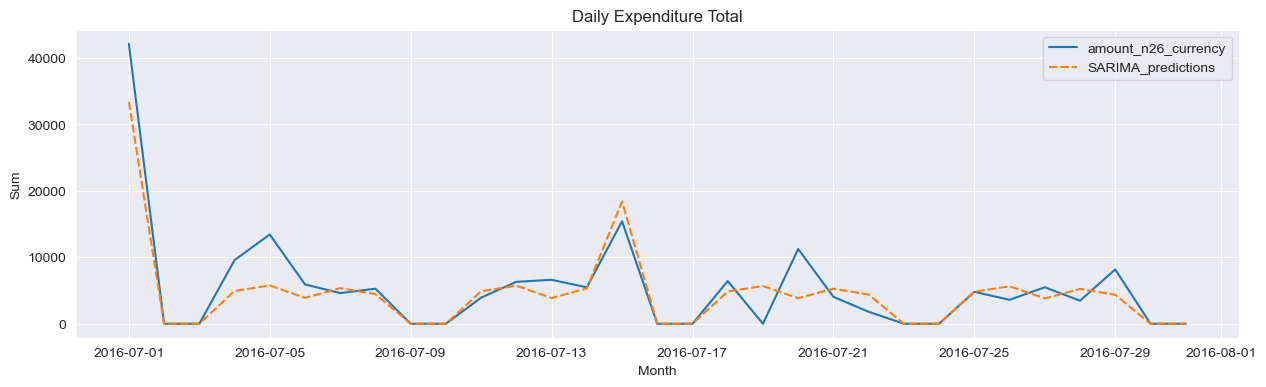

In [296]:
#plotting results
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=expenditure_dd_test[['amount_n26_currency','SARIMA_predictions']], 
            # x='transaction_date',
            # y='amount_n26_currency',
            ax=ax, 
            estimator='count',
            )
plt.xlabel("Month")
plt.ylabel("Sum")
plt.title('Daily Expenditure Total')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [297]:
# metrics for expenditure model 
print('root mean squared error')
print(rmse(expenditure_dd_test['amount_n26_currency'],expenditure_dd_test['SARIMA_predictions']))
print('-----------------------------')
print('mean absolute error')
print(meanabs(expenditure_dd_test['amount_n26_currency'],expenditure_dd_test['SARIMA_predictions']))

root mean squared error
3123.3558793519182
-----------------------------
mean absolute error
1932.2323747015157


### the model looks very good, the best results I think we have seen so far

In [298]:
expenditure_model = (SARIMAX(expenditure_direct_debits['amount_n26_currency'],
                             exog=expenditure_direct_debits[['dd_spike_1','dd_spike_2']], 
                             order=(0, 0, 0),
                             seasonal_order=(1, 0, 1, 7),
                             enforce_invertibility=False)
                    .fit(maxiter=100))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42069D+00    |proj g|=  6.86313D-02

At iterate    5    f=  9.39378D+00    |proj g|=  4.11054D-02

At iterate   10    f=  9.38872D+00    |proj g|=  4.75677D-03


 This problem is unconstrained.



At iterate   15    f=  9.38871D+00    |proj g|=  8.84164D-04

At iterate   20    f=  9.38867D+00    |proj g|=  1.29780D-02

At iterate   25    f=  9.38678D+00    |proj g|=  6.03790D-03

At iterate   30    f=  9.38415D+00    |proj g|=  5.28446D-02

At iterate   35    f=  9.38063D+00    |proj g|=  1.83368D-02

At iterate   40    f=  9.38057D+00    |proj g|=  1.93326D-04

At iterate   45    f=  9.38056D+00    |proj g|=  3.99764D-03

At iterate   50    f=  9.38019D+00    |proj g|=  3.42856D-02

At iterate   55    f=  9.36744D+00    |proj g|=  5.42674D-01

At iterate   60    f=  9.27673D+00    |proj g|=  1.10608D-01

At iterate   65    f=  9.27499D+00    |proj g|=  1.89610D-02

At iterate   70    f=  9.27196D+00    |proj g|=  1.33078D-01

At iterate   75    f=  9.26465D+00    |proj g|=  1.23611D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

In [299]:
# creating the august dataframe with the exogenous x variables
august_expenditure_dd = pd.DataFrame(pd.date_range('2016-08-01','2016-08-31',freq='D'),columns=['date'])
august_expenditure_dd = august_expenditure_dd.set_index('date')
august_expenditure_dd.index.freq = 'd'
august_expenditure_dd['dd_spike_1'] = np.where(pd.Series(august_expenditure_dd.index).isin(dd_spike_1),1,0)
august_expenditure_dd['dd_spike_2'] = np.where(pd.Series(august_expenditure_dd.index).isin(dd_spike_2),1,0)

In [300]:
# need to recreate this as it is different form my train test split
start = len(expenditure_direct_debits)
end = len(expenditure_direct_debits) + len(august_expenditure_dd) - 1

In [301]:
# creating predictions
expenditure_predictions = (expenditure_model.predict(start,end,typ='levels',exog=august_expenditure_dd[['dd_spike_1','dd_spike_2',]])
                        .rename('SARIMA Predictions'))
august_expenditure_dd['SARIMA_predictions'] = expenditure_predictions

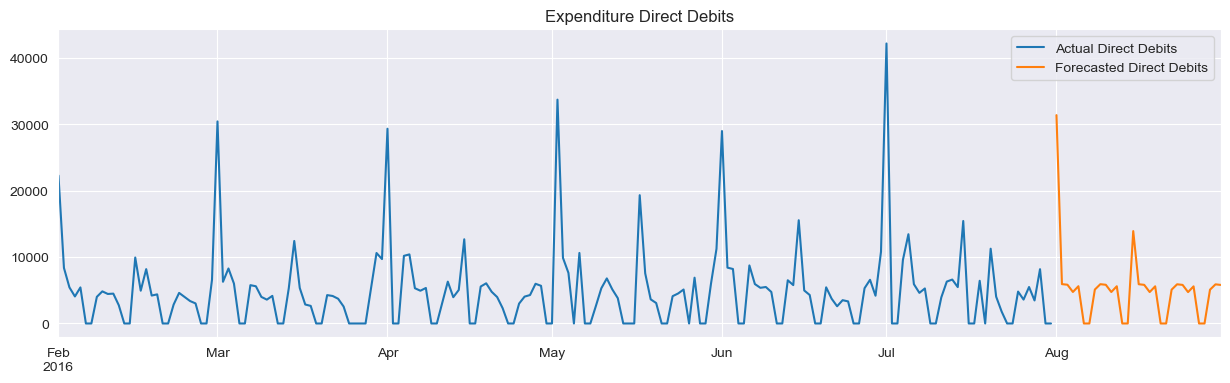

In [379]:
expenditure_direct_debits['amount_n26_currency'].plot(figsize=(15,4),legend=True)
august_expenditure_dd['SARIMA_predictions'].plot(legend=True)
plt.legend(title=None, loc='upper right', labels=['Actual Direct Debits','Forecasted Direct Debits'])
plt.title('Expenditure Direct Debits')
plt.xlabel('')
plt.show()

In [303]:
file = open('models/expenditure_direct_debits_model.pkl', 'wb+')
pickle.dump(expenditure_model, file)

### Next is debit transfers

In [304]:
print('Augmented Dickey-Fuller Test on Income')
test = adfuller(expenditure_debit_transfers['amount_n26_currency'],autolag='AIC')
output = pd.Series(test[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in test[4].items():
    output[f'critical value ({key})']=val
print(output)

Augmented Dickey-Fuller Test on Income
ADF test statistic       -4.468345
p-value                   0.000224
# lags used              14.000000
# observations          167.000000
critical value (1%)      -3.470126
critical value (5%)      -2.879008
critical value (10%)     -2.576083
dtype: float64


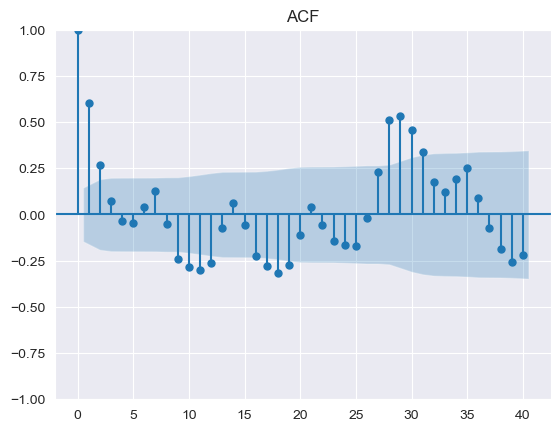

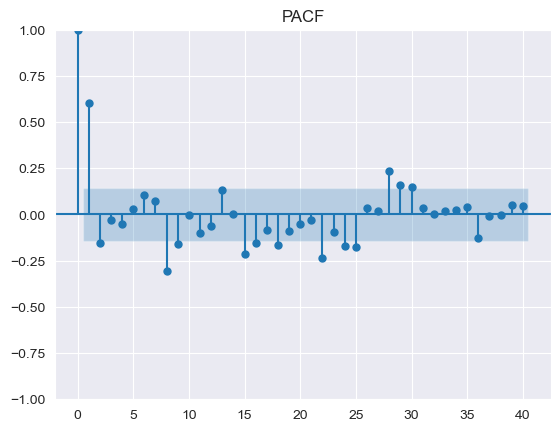

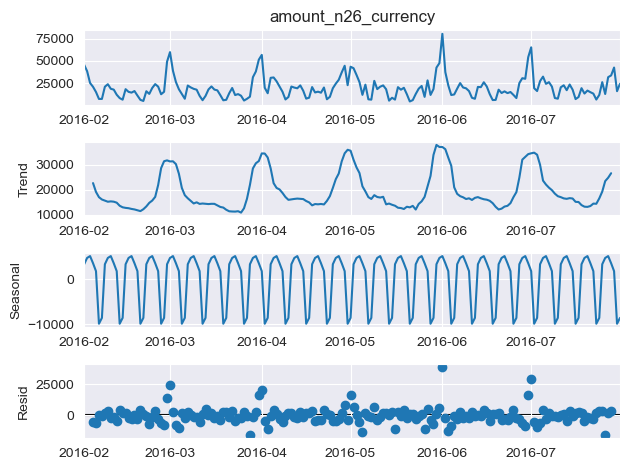

In [305]:
plot_acf(expenditure_debit_transfers['amount_n26_currency'],title='ACF',lags=40);
plot_pacf(expenditure_debit_transfers['amount_n26_currency'],title='PACF',lags=40, method='ywm');
seasonal_decompose(expenditure_debit_transfers['amount_n26_currency'],model='add').plot();

In [306]:
# hardcoding debit transfer spike dates i.e first of the month 
dt_spike = pd.to_datetime(['2016-02-01','2016-03-01','2016-04-01','2016-05-01','2016-06-01','2016-07-01','2016-08-01'])

In [307]:
# adding dt spike dates
expenditure_debit_transfers['dt_spike'] = np.where(pd.Series(expenditure_debit_transfers.index).isin(dt_spike),1,0)

In [308]:
# creating train test split
expenditure_dt_train = expenditure_debit_transfers.iloc[:151]
expenditure_dt_test = expenditure_debit_transfers.iloc[151:]

In [309]:
# I use autoarima to do a grid search and find the best model, note that we use AIC which penalises increased complexity as the evaluation metric
stepwise_fit_expenditure = auto_arima(expenditure_debit_transfers['amount_n26_currency'],
                                 exogenous=expenditure_debit_transfers[['dt_spike']],
                                 start_p=0,
                                 start_q=0,
                                 max_p=4,
                                 max_q=4,
                                 seasonal=True,
                                #  trace=True,
                                 m=7)
stepwise_fit_expenditure.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  182
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2], 7)   Log Likelihood               -1932.890
Date:                                Wed, 22 Feb 2023   AIC                           3879.781
Time:                                        12:40:07   BIC                           3902.209
Sample:                                    02-01-2016   HQIC                          3888.873
                                         - 07-31-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.306e+04   1908.551      6.842      0.000    9317.389    1.68e+04
dt_spike    5.866e+04   2169.475     27.040      0.000    5.44e+04    6.29e+04
ar.L1          0.1647      0.050      3.305      0.001       0.067       0.262
ar.L2          0.1123      0.065      1.722      0.085      -0.016       0.240
ma.S.L7        0.2684      0.116      2.311      0.021       0.041       0.496
ma.S.L14       0.1492      0.128      1.169      0.242      -0.101       0.399
sigma2      9.922e+07      0.498   1.99e+08      0.000    9.92e+07    9.92e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                60.49
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.68
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.82e+23. Standard errors may be unstable.
"""

In [310]:
# note here I ran the original results from the model, I manually adjusted the P to 1 which is a better model 
expenditure_model = (SARIMAX(expenditure_dt_train['amount_n26_currency'],
                             exog=expenditure_dt_train[['dt_spike']], 
                             order=(2, 0, 0),
                             seasonal_order=(1, 0, 2, 7),
                             enforce_invertibility=False)
                    .fit(maxiter=100))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08292D+01    |proj g|=  1.21790D+00

At iterate    5    f=  1.06798D+01    |proj g|=  5.02144D-02

At iterate   10    f=  1.06669D+01    |proj g|=  8.97267D-02

At iterate   15    f=  1.06438D+01    |proj g|=  9.36607D-03

At iterate   20    f=  1.06424D+01    |proj g|=  3.04940D-02

At iterate   25    f=  1.06382D+01    |proj g|=  2.76041D-02

At iterate   30    f=  1.06380D+01    |proj g|=  3.83534D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [311]:
# need to create start and end range for predictions 
start = len(expenditure_dt_train)
end = len(expenditure_dt_train) + len(expenditure_dt_test) - 1

In [312]:
# creating predictions
expenditure_predictions = (expenditure_model.predict(start,end,typ='levels',exog=expenditure_dt_test[['dt_spike']])
                                .rename('SARIMA Predictions'))
expenditure_dt_test['SARIMA_predictions'] = expenditure_predictions

/var/folders/jk/7_97xl9d43v9l_jqg7kbpf9m0000gn/T/ipykernel_5982/3658152649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditure_dt_test['SARIMA_predictions'] = expenditure_predictions


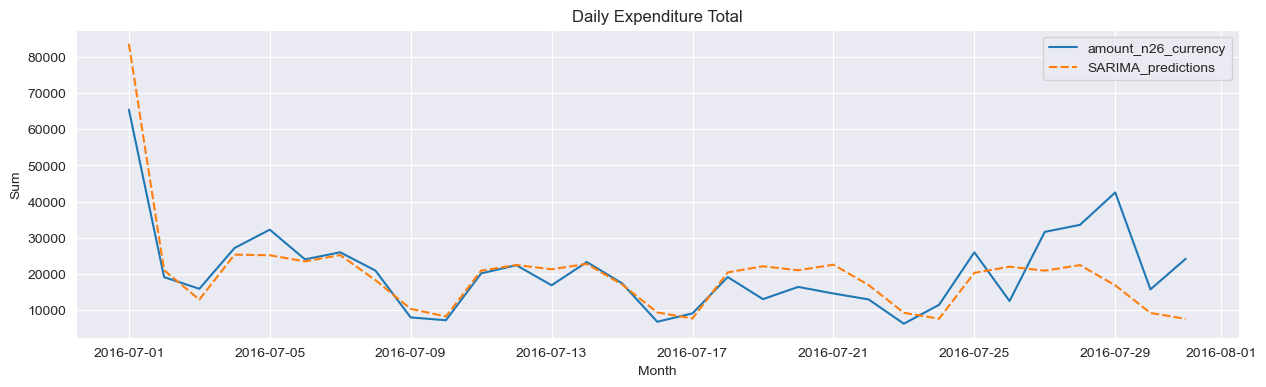

In [313]:
#plotting results
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=expenditure_dt_test[['amount_n26_currency','SARIMA_predictions']], 
            # x='transaction_date',
            # y='amount_n26_currency',
            ax=ax, 
            estimator='count',
            )
plt.xlabel("Month")
plt.ylabel("Sum")
plt.title('Daily Expenditure Total')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [314]:
# metrics for expenditure model 
print('root mean squared error')
print(rmse(expenditure_dt_test['amount_n26_currency'],expenditure_dt_test['SARIMA_predictions']))
print('-----------------------------')
print('mean absolute error')
print(meanabs(expenditure_dt_test['amount_n26_currency'],expenditure_dt_test['SARIMA_predictions']))

root mean squared error
7998.771775043255
-----------------------------
mean absolute error
5446.3479885368415


### Again the model looks pretty good

In [315]:
# creating the august dataframe with the exogenous x variables
august_expenditure_dt = pd.DataFrame(pd.date_range('2016-08-01','2016-08-31',freq='D'),columns=['date'])
august_expenditure_dt = august_expenditure_dt.set_index('date')
august_expenditure_dt.index.freq = 'd'
august_expenditure_dt['dt_spike'] = np.where(pd.Series(august_expenditure_dt.index).isin(dt_spike),1,0)

In [316]:
expenditure_model = (SARIMAX(expenditure_debit_transfers['amount_n26_currency'],
                             exog=expenditure_debit_transfers[['dt_spike']], 
                             order=(1, 0, 0),
                             seasonal_order=(1, 0, 2, 7),
                             enforce_invertibility=False)
                    .fit(maxiter=100))
                    


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08690D+01    |proj g|=  1.86921D+00

At iterate    5    f=  1.07572D+01    |proj g|=  6.47773D-02

At iterate   10    f=  1.06990D+01    |proj g|=  2.95143D-01

At iterate   15    f=  1.06902D+01    |proj g|=  1.58467D-02

At iterate   20    f=  1.06892D+01    |proj g|=  2.45425D-02

At iterate   25    f=  1.06818D+01    |proj g|=  2.00515D-02

At iterate   30    f=  1.06813D+01    |proj g|=  5.30867D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [317]:
# need to recreate this as it is different form my train test split
start = len(expenditure_debit_transfers)
end = len(expenditure_debit_transfers) + len(august_expenditure_dt) - 1

In [318]:
# creating predictions
expenditure_predictions = (expenditure_model.predict(start,end,typ='levels',exog=august_expenditure_dt[['dt_spike']])
                        .rename('SARIMA Predictions'))
august_expenditure_dt['SARIMA_predictions'] = expenditure_predictions



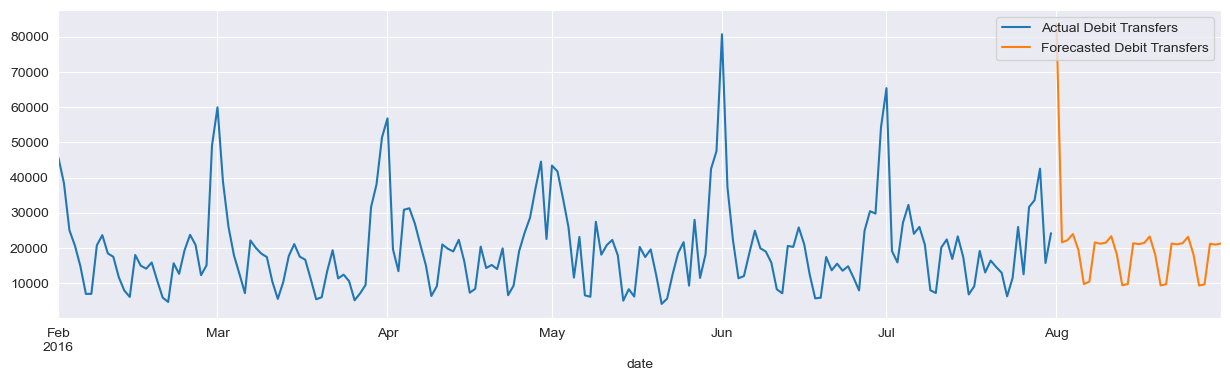

In [319]:
expenditure_debit_transfers['amount_n26_currency'].plot(figsize=(15,4),legend=True)
august_expenditure_dt['SARIMA_predictions'].plot(legend=True)
plt.legend(title=None, loc='upper right', labels=['Actual Debit Transfers','Forecasted Debit Transfers'])
plt.show()



In [320]:
file = open('models/expenditure_debits_transfers_model.pkl', 'wb+')
pickle.dump(expenditure_model, file)

### groceries model

In [321]:
print('Augmented Dickey-Fuller Test on Income')
test = adfuller(expenditure_groceries['amount_n26_currency'],autolag='AIC')
output = pd.Series(test[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in test[4].items():
    output[f'critical value ({key})']=val
print(output)

Augmented Dickey-Fuller Test on Income
ADF test statistic       -2.821530
p-value                   0.055264
# lags used              14.000000
# observations          167.000000
critical value (1%)      -3.470126
critical value (5%)      -2.879008
critical value (10%)     -2.576083
dtype: float64


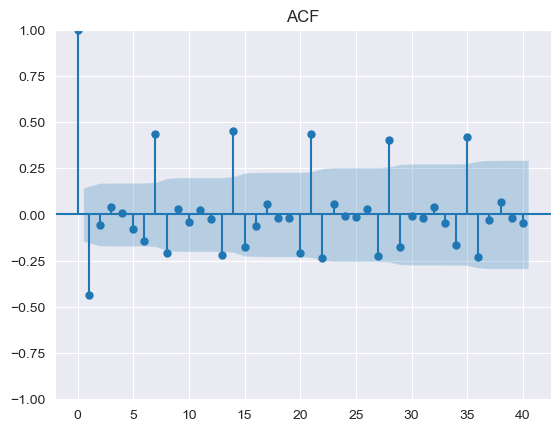

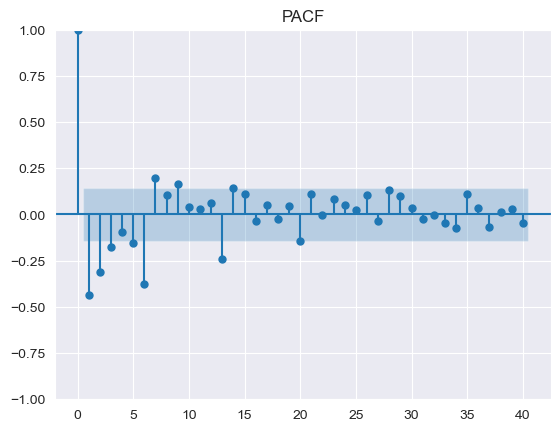

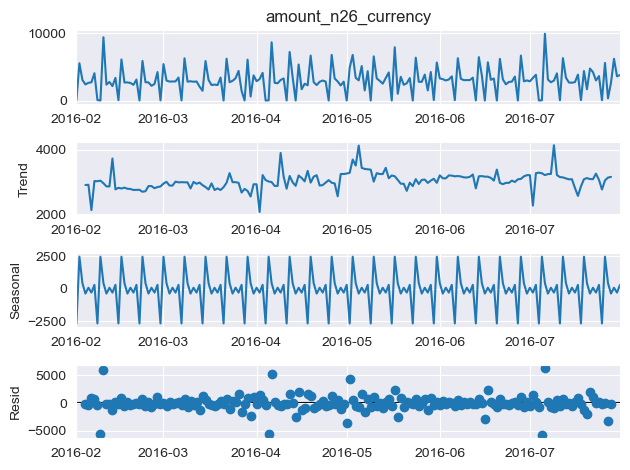

In [322]:
plot_acf(expenditure_groceries['amount_n26_currency'],title='ACF',lags=40);
plot_pacf(expenditure_groceries['amount_n26_currency'],title='PACF',lags=40, method='ywm');
seasonal_decompose(expenditure_groceries['amount_n26_currency'],model='add').plot();

In [323]:
# creating train test split
expenditure_groceries_train = expenditure_groceries.iloc[:151]
expenditure_groceries_test = expenditure_groceries.iloc[151:]

In [324]:
stepwise_fit_expenditure = auto_arima(expenditure_groceries['amount_n26_currency'],
                                #  exogenous=expenditure_groceries_train[['dt_spike']],
                                 start_p=0,
                                 start_q=0,
                                 max_p=4,
                                 max_q=4,
                                 seasonal=True,
                                #  trace=True,
                                 m=7)
stepwise_fit_expenditure.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  182
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -1584.827
Date:                                Wed, 22 Feb 2023   AIC                           3179.654
Time:                                        12:40:15   BIC                           3195.674
Sample:                                             0   HQIC                          3186.148
                                                - 182                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3041.3128     56.171     54.143      0.000    2931.219    3151.407
ma.L1         -0.7058      0.046    -15.430      0.000      -0.795      -0.616
ma.S.L7        0.3038      0.064      4.754      0.000       0.179       0.429
ma.S.L14       0.2918      0.085      3.416      0.001       0.124       0.459
sigma2      2.119e+06   1.87e+05     11.345      0.000    1.75e+06    2.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.88
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.41
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [325]:
expenditure_model = (SARIMAX(expenditure_groceries_train['amount_n26_currency'],
                             order=(0, 0, 1),
                             seasonal_order=(1, 0, 2, 7),
                             enforce_invertibility=False)
                    .fit(maxiter=100))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.26129D+00    |proj g|=  4.92280D-01

At iterate    5    f=  9.22891D+00    |proj g|=  1.27327D-02

At iterate   10    f=  9.22696D+00    |proj g|=  5.58628D-03

At iterate   15    f=  9.22581D+00    |proj g|=  3.16207D-04

At iterate   20    f=  9.22579D+00    |proj g|=  3.16898D-03

At iterate   25    f=  9.22341D+00    |proj g|=  3.52467D-02


 This problem is unconstrained.



At iterate   30    f=  9.10776D+00    |proj g|=  2.84423D-01

At iterate   35    f=  8.80602D+00    |proj g|=  4.60737D-01

At iterate   40    f=  8.60670D+00    |proj g|=  1.53038D-01

At iterate   45    f=  8.60513D+00    |proj g|=  3.65743D-03

At iterate   50    f=  8.60511D+00    |proj g|=  2.14827D-02

At iterate   55    f=  8.60178D+00    |proj g|=  3.14786D-02

At iterate   60    f=  8.60098D+00    |proj g|=  6.78670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     64     88      1     0     0   1.154D-05   8.601D+00
  F =   8.6009761770514288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [326]:
# need to create start and end range for predictions 
start = len(expenditure_groceries_train)
end = len(expenditure_groceries_train) + len(expenditure_groceries_test) - 1

In [327]:
# creating predictions
expenditure_predictions = (expenditure_model.predict(start,end,typ='levels')
                                .rename('SARIMA Predictions'))
expenditure_groceries_test['SARIMA_predictions'] = expenditure_predictions

/var/folders/jk/7_97xl9d43v9l_jqg7kbpf9m0000gn/T/ipykernel_5982/1329152199.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditure_groceries_test['SARIMA_predictions'] = expenditure_predictions


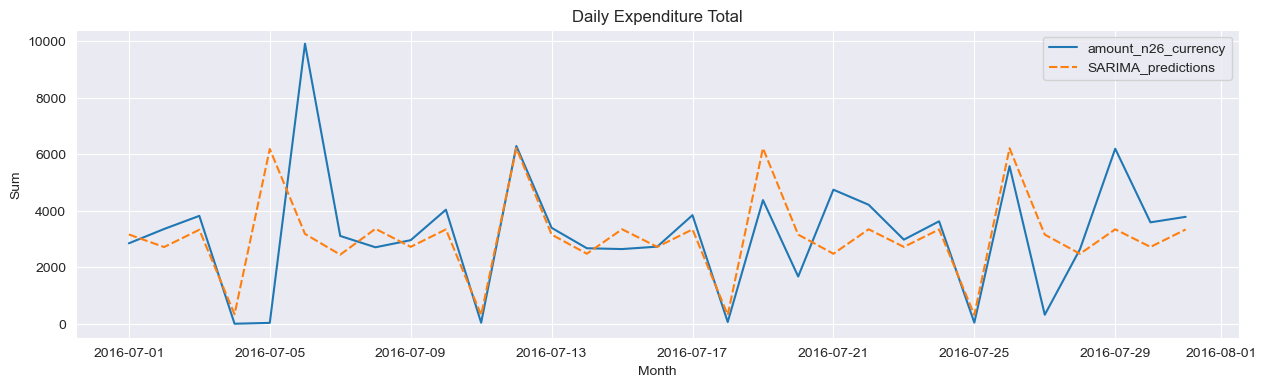

In [328]:
#plotting results
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=expenditure_groceries_test[['amount_n26_currency','SARIMA_predictions']], 
            # x='transaction_date',
            # y='amount_n26_currency',
            ax=ax, 
            estimator='count',
            )
plt.xlabel("Month")
plt.ylabel("Sum")
plt.title('Daily Expenditure Total')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [329]:
# metrics for expenditure model 
print('root mean squared error')
print(rmse(expenditure_groceries_test['amount_n26_currency'],expenditure_groceries_test['SARIMA_predictions']))
print('-----------------------------')
print('mean absolute error')
print(meanabs(expenditure_groceries_test['amount_n26_currency'],expenditure_groceries_test['SARIMA_predictions']))

root mean squared error
1931.7406647273922
-----------------------------
mean absolute error
1104.3696943128189


In [330]:
expenditure_model = (SARIMAX(expenditure_groceries['amount_n26_currency'], 
                             order=(0, 0, 1),
                             seasonal_order=(1, 0, 2, 7),
                             enforce_invertibility=False)
                    .fit(maxiter=100))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25914D+00    |proj g|=  1.93119D-01

At iterate    5    f=  9.24367D+00    |proj g|=  1.70108D-02

At iterate   10    f=  9.23991D+00    |proj g|=  1.07852D-02

At iterate   15    f=  9.23789D+00    |proj g|=  9.54929D-04


 This problem is unconstrained.



At iterate   20    f=  9.23788D+00    |proj g|=  1.94799D-03

At iterate   25    f=  9.23697D+00    |proj g|=  3.98613D-02

At iterate   30    f=  9.20746D+00    |proj g|=  1.34528D-01

At iterate   35    f=  9.11484D+00    |proj g|=  1.83952D+00

At iterate   40    f=  8.84854D+00    |proj g|=  1.02843D+00

At iterate   45    f=  8.72514D+00    |proj g|=  3.87119D-01

At iterate   50    f=  8.67891D+00    |proj g|=  4.08614D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     52     84      1     0     0   8.525D-05   8.679D+00
  F =   8.6789127761551423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [331]:
# creating the august dataframe with the exogenous x variables
august_expenditure_groceries = pd.DataFrame(pd.date_range('2016-08-01','2016-08-31',freq='D'),columns=['date'])
august_expenditure_groceries = august_expenditure_groceries.set_index('date')
august_expenditure_groceries.index.freq = 'd'

In [332]:
# need to recreate this as it is different form my train test split
start = len(expenditure_groceries)
end = len(expenditure_groceries) + len(august_expenditure_groceries) - 1

In [333]:
# creating predictions
expenditure_predictions = (expenditure_model.predict(start,end,typ='levels')
                        .rename('SARIMA Predictions'))
august_expenditure_groceries['SARIMA_predictions'] = expenditure_predictions

In [334]:
# model produce one negative value, dont have time to do a full fix, so need to manually set this to zero
august_expenditure_groceries[august_expenditure_groceries < 0] = 0

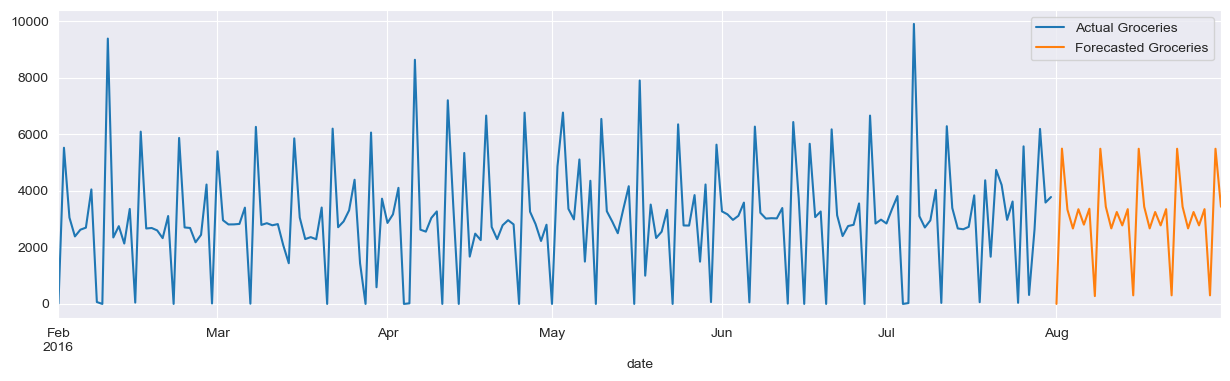

In [335]:
expenditure_groceries['amount_n26_currency'].plot(figsize=(15,4),legend=True)
august_expenditure_groceries['SARIMA_predictions'].plot(legend=True)
plt.legend(title=None, loc='upper right', labels=['Actual Groceries','Forecasted Groceries'])
plt.show()

In [336]:
file = open('models/expenditure_groceries_model.pkl', 'wb+')
pickle.dump(expenditure_model, file)

### Finally the remaining expenditure

In [337]:
print('Augmented Dickey-Fuller Test on Income')
test = adfuller(expenditure_misc['amount_n26_currency'],autolag='AIC')
output = pd.Series(test[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in test[4].items():
    output[f'critical value ({key})']=val
print(output)

Augmented Dickey-Fuller Test on Income
ADF test statistic       -3.614988
p-value                   0.005481
# lags used              13.000000
# observations          168.000000
critical value (1%)      -3.469886
critical value (5%)      -2.878903
critical value (10%)     -2.576027
dtype: float64


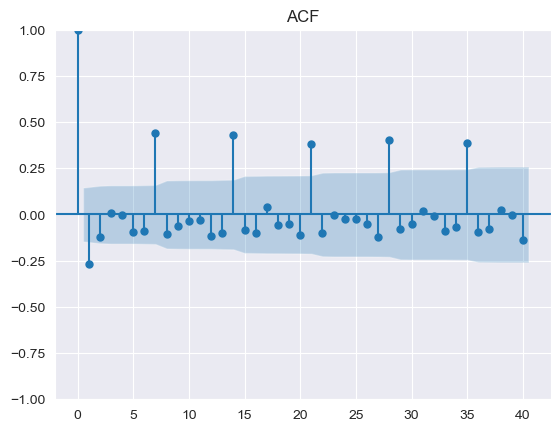

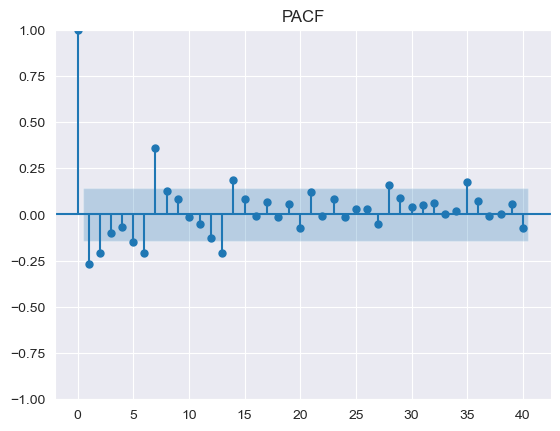

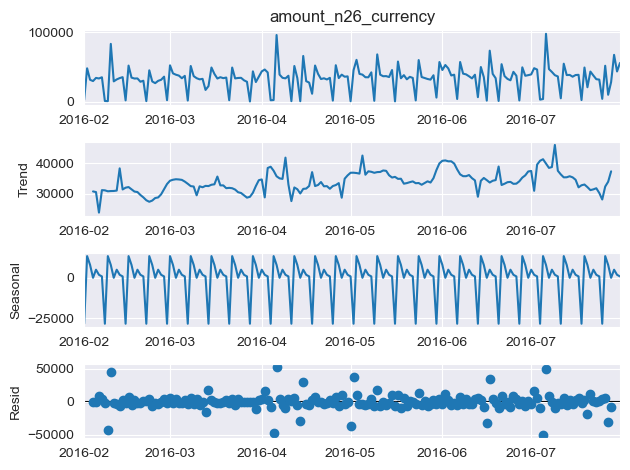

In [338]:
plot_acf(expenditure_misc['amount_n26_currency'],title='ACF',lags=40);
plot_pacf(expenditure_misc['amount_n26_currency'],title='PACF',lags=40, method='ywm');
seasonal_decompose(expenditure_misc['amount_n26_currency'],model='add').plot();

In [339]:
# creating train test split
expenditure_misc_train = expenditure_misc.iloc[:151]
expenditure_misc_test = expenditure_misc.iloc[151:]

In [340]:
stepwise_fit_expenditure = auto_arima(expenditure_misc['amount_n26_currency'],
                                 start_p=0,
                                 start_q=0,
                                 max_p=4,
                                 max_q=4,
                                 seasonal=True,
                                #  trace=True,
                                 m=7)
stepwise_fit_expenditure.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  182
Model:             SARIMAX(4, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -1979.250
Date:                             Wed, 22 Feb 2023   AIC                           3976.500
Time:                                     12:40:57   BIC                           4005.286
Sample:                                          0   HQIC                          3988.170
                                             - 182                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3387      0.165     -8.137      0.000      -1.661      -1.016
ar.L2         -0.6128      0.177     -3.460      0.001      -0.960      -0.266
ar.L3         -0.3307      0.233     -1.421      0.155      -0.787       0.125
ar.L4         -0.1153      0.165     -0.698      0.485      -0.439       0.209
ma.L1         -0.0308      0.171     -0.180      0.857      -0.366       0.304
ma.L2         -0.9396      0.175     -5.369      0.000      -1.283      -0.597
ar.S.L7        0.9933      0.019     53.317      0.000       0.957       1.030
ma.S.L7       -0.9035      0.134     -6.732      0.000      -1.167      -0.640
sigma2      2.422e+08   4.39e-10   5.52e+17      0.000    2.42e+08    2.42e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                53.54
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.41
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.19e+33. Standard errors may be unstable.
"""

In [341]:
expenditure_model = (SARIMAX(expenditure_misc_train['amount_n26_currency'],
                             order=(4, 1, 2),
                             seasonal_order=(1, 0, 1, 7),
                             enforce_invertibility=False)
                    .fit(maxiter=100))

/opt/anaconda3/envs/n26/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20404D+01    |proj g|=  1.71568D-01

At iterate    5    f=  1.08738D+01    |proj g|=  1.19125D-01

At iterate   10    f=  1.08437D+01    |proj g|=  5.16462D-02

At iterate   15    f=  1.08121D+01    |proj g|=  4.34828D-02

At iterate   20    f=  1.07973D+01    |proj g|=  2.63526D-02

At iterate   25    f=  1.07956D+01    |proj g|=  2.50411D-03

At iterate   30    f=  1.07956D+01    |proj g|=  4.18787D-04

At iterate   35    f=  1.07956D+01    |proj g|=  2.52822D-03

At iterate   40    f=  1.07953D+01    |proj g|=  6.22914D-03

At iterate   45    f=  1.07950D+01    |proj g|=  8.12461D-03

At iterate   50    f=  1.07949D+01    |proj g|=  3.64075D-04

At iterate   55    f=  1.07949D+01    |proj g|=  1.99441D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

In [342]:
# need to create start and end range for predictions 
start = len(expenditure_misc_train)
end = len(expenditure_misc_train) + len(expenditure_misc_test) - 1

In [343]:
# creating predictions
expenditure_predictions = (expenditure_model.predict(start,end,typ='levels')
                                .rename('SARIMA Predictions'))
expenditure_misc_test['SARIMA_predictions'] = expenditure_predictions

/var/folders/jk/7_97xl9d43v9l_jqg7kbpf9m0000gn/T/ipykernel_5982/858578768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditure_misc_test['SARIMA_predictions'] = expenditure_predictions


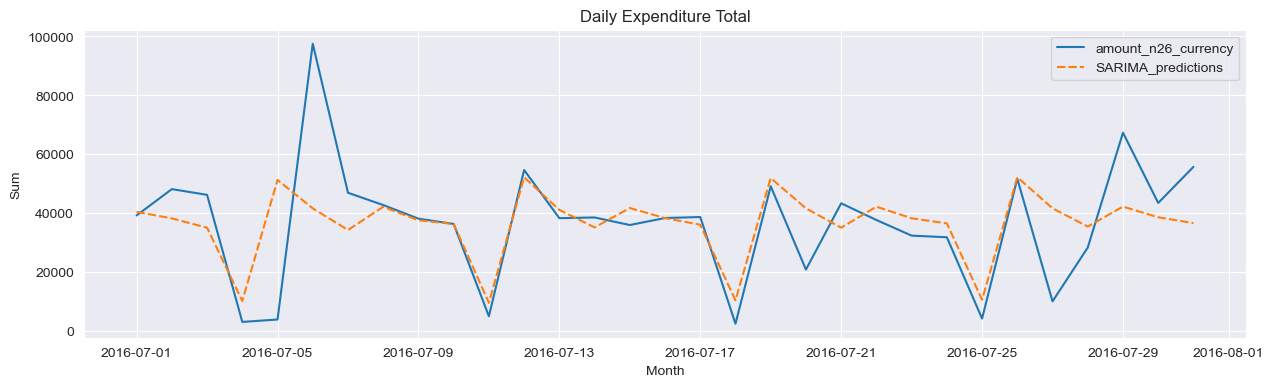

In [344]:
#plotting results
fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=expenditure_misc_test[['amount_n26_currency','SARIMA_predictions']], 
            # x='transaction_date',
            # y='amount_n26_currency',
            ax=ax, 
            estimator='count',
            )
plt.xlabel("Month")
plt.ylabel("Sum")
plt.title('Daily Expenditure Total')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [345]:
# metrics for expenditure model 
print('root mean squared error')
print(rmse(expenditure_misc_test['amount_n26_currency'],expenditure_groceries_test['SARIMA_predictions']))
print('-----------------------------')
print('mean absolute error')
print(meanabs(expenditure_misc_test['amount_n26_currency'],expenditure_groceries_test['SARIMA_predictions']))

root mean squared error
38733.31974361701
-----------------------------
mean absolute error
33547.735948588794


In [346]:
expenditure_model = (SARIMAX(expenditure_misc['amount_n26_currency'], 
                             order=(4, 1, 2),
                             seasonal_order=(1, 0, 1, 7),
                             enforce_invertibility=False)
                    .fit(maxiter=100))

/opt/anaconda3/envs/n26/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21003D+01    |proj g|=  1.74004D-01

At iterate    5    f=  1.10831D+01    |proj g|=  2.11363D-01

At iterate   10    f=  1.09364D+01    |proj g|=  4.39509D-02

At iterate   15    f=  1.09171D+01    |proj g|=  1.58197D-01

At iterate   20    f=  1.08827D+01    |proj g|=  3.89944D-02

At iterate   25    f=  1.08754D+01    |proj g|=  2.63026D-02

At iterate   30    f=  1.08750D+01    |proj g|=  2.64927D-03

At iterate   35    f=  1.08750D+01    |proj g|=  1.89336D-04

At iterate   40    f=  1.08750D+01    |proj g|=  1.84899D-03

At iterate   45    f=  1.08750D+01    |proj g|=  5.18156D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [347]:
# creating the august dataframe with the exogenous x variables
august_expenditure_misc = pd.DataFrame(pd.date_range('2016-08-01','2016-08-31',freq='D'),columns=['date'])
august_expenditure_misc = august_expenditure_misc.set_index('date')
august_expenditure_misc.index.freq = 'd'




In [348]:
# need to recreate this as it is different form my train test split
start = len(expenditure_misc)
end = len(expenditure_misc) + len(august_expenditure_misc) - 1



In [349]:
# creating predictions
expenditure_predictions = (expenditure_model.predict(start,end,typ='levels')
                        .rename('SARIMA Predictions'))
august_expenditure_misc['SARIMA_predictions'] = expenditure_predictions



In [350]:
# model produce one negative value, dont have time to do a full fix, so need to manually set this to zero
august_expenditure_misc[august_expenditure_misc < 0] = 0

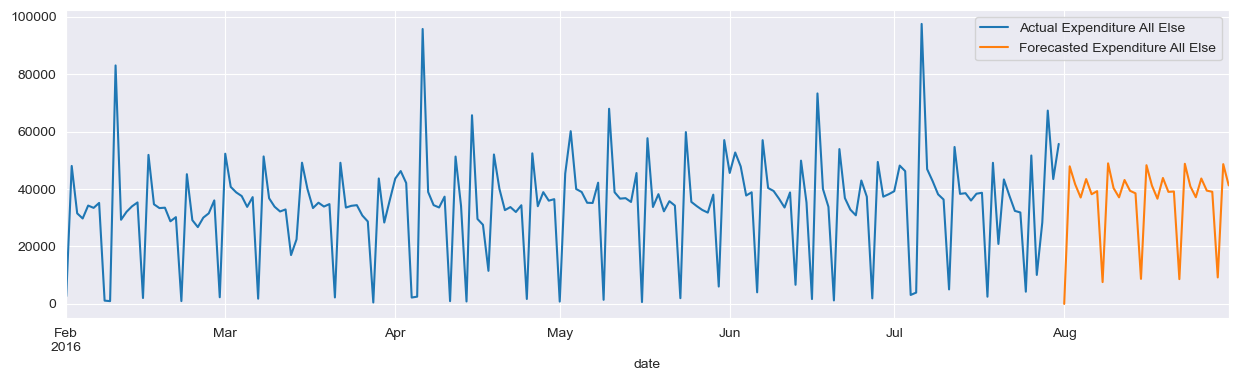

In [351]:
expenditure_misc['amount_n26_currency'].plot(figsize=(15,4),legend=True)
august_expenditure_misc['SARIMA_predictions'].plot(legend=True)
plt.legend(title=None, loc='upper right', labels=['Actual Expenditure All Else','Forecasted Expenditure All Else'])
plt.show()



In [352]:
file = open('models/expenditure_misc_model.pkl', 'wb+')
pickle.dump(expenditure_model, file)

In [353]:
august_expenditure_misc = august_expenditure_misc.rename(columns={'SARIMA_predictions':'All Else Forecast'})
august_expenditure_groceries = august_expenditure_groceries.rename(columns={'SARIMA_predictions':'Groceries Forecast'})
august_expenditure_dd = august_expenditure_dd.rename(columns={'SARIMA_predictions':'Direct Debit Forecast'})
august_expenditure_dt = august_expenditure_dt.rename(columns={'SARIMA_predictions':'Debit Transfer Forecast'})

In [354]:
august_expenditure_forecast = august_expenditure_misc.merge(august_expenditure_groceries, how='left',left_index=True,right_index=True)
august_expenditure_forecast = august_expenditure_forecast.merge(august_expenditure_dd, how='left',left_index=True,right_index=True)
august_expenditure_forecast = august_expenditure_forecast.merge(august_expenditure_dt, how='left',left_index=True,right_index=True)


In [355]:
august_expenditure_forecast['Total'] = (august_expenditure_forecast['All Else Forecast']
                                        + august_expenditure_forecast['Groceries Forecast']
                                        + august_expenditure_forecast['Direct Debit Forecast']
                                        + august_expenditure_forecast['Debit Transfer Forecast'])
                  

In [356]:
expenditure = data[data['direction']=='Out'].copy()
expenditure = expenditure.groupby('transaction_date').sum(numeric_only=True)
expenditure.index.freq = 'd'

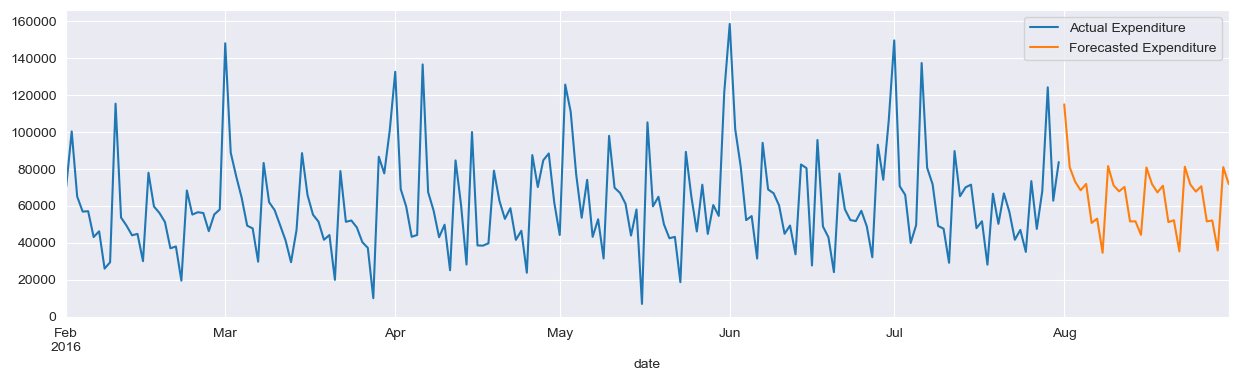

In [357]:
expenditure['amount_n26_currency'].plot(figsize=(15,4),legend=True)
august_expenditure_forecast['Total'].plot(legend=True)
plt.legend(title=None, loc='upper right', labels=['Actual Expenditure','Forecasted Expenditure'])
plt.show()

In [358]:
august_expenditure_forecast.to_csv('predictions/august_expenditure_forecast.csv')

# I never got time to complete the bonus clustering task, however I left some of my code in the document as I think it demonstrates more of my skills

# 4. Clustering 

### Having looked at the data I think there is a really good case for creating clusters seperating out different types of customers, there are a number of reasons that this could potentially be a really useful thing to do. 

### - Different types of customers will have different risk profiles associated when it comes to making credit decisions
### - Forecasts will be more accurate for customers who regularly use the platform
### - Understanding different groups allows the tailoring of our service based on different needs 
### - Seperating out in active or customers who have churned will help tailor and optimise marketing strategy 

In [359]:
# firts attempting to create clusters for different levels of activity
clustering_features = (data
    .pivot_table(values='amount_n26_currency', 
                 index=['user_id'],
                 columns=['month'],
                 aggfunc='count')
)

### note that normally scaling is required for clustering because, linear distance measures are used in the model, in this case this is not neccesary as the inputs are all in the same scale 

In [360]:
ks = [k for k in range(2,11)]
sils = []

for k in ks:
    km = KMeans(n_clusters=k,n_init='auto')
    km.fit(clustering_features)
    sils.append(silhouette_score(clustering_features,km.predict(clustering_features)))

results_df = pd.DataFrame({"K":ks,
                           "silhouette":sils})

print(results_df)

    K  silhouette
0   2    0.580090
1   3    0.465117
2   4    0.385275
3   5    0.366646
4   6    0.342458
5   7    0.333579
6   8    0.287037
7   9    0.298764
8  10    0.285681


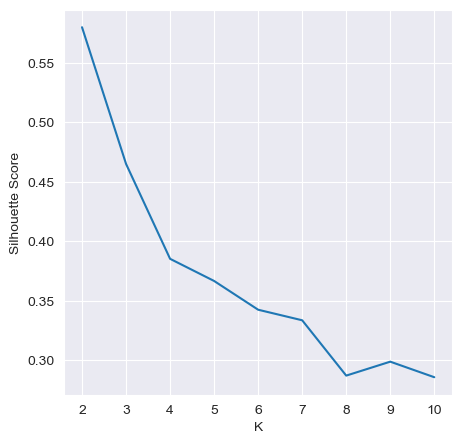

In [361]:
fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(data=results_df, 
            x='K',
            y='silhouette',
            ax=ax
            )
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [362]:
km = KMeans(n_clusters=2,n_init='auto')
km.fit(clustering_features)
clusters = km.predict(clustering_features)
clustering_features['cluster'] = clusters

In [363]:
clustering_features[clustering_features['cluster'] == 0]

month,February,March,April,May,June,July,cluster
user_id,,,,,,,
000295594379774ab9ac2c78c946d615,2,5,0,3,7,1,0
000aa792d73dd82b16a29692772d395a,7,1,5,5,3,4,0
0011103fe4ba1264342882b7ab98c641,1,1,5,2,3,20,0
001e72a2f4c4376f10011735dde39cd5,8,8,4,2,0,0,0
001f9baedaf3c8487c344d25b0eda9fc,4,7,4,3,3,0,0
...,...,...,...,...,...,...,...
ffebcd13c2f389dd6c47a76179ef1dee,0,1,1,0,0,0,0
fff571276eaa49853039f6bfe1102fba,0,2,2,0,2,2,0
fff6ea4b3659a969c62c17c1d1655394,1,2,1,2,0,1,0


In [364]:
clustering_features[clustering_features['cluster'] == 1]

month,February,March,April,May,June,July,cluster
user_id,,,,,,,
001679c77c33d7efabf800596fb2a978,7,2,17,20,17,15,1
0048233ffb64776094f7b3d390ff1d76,10,12,21,21,23,8,1
0082dace2f94dbb8a336cd15554005f6,19,23,20,16,20,26,1
009f41108caa00c8b9f1da8a7ab43a20,14,18,5,7,14,13,1
00e07dbe5c541ee1ab4f65ea0cd52b45,11,3,18,6,10,21,1
...,...,...,...,...,...,...,...
ffa96cd1e0b085d43fa18130be54290d,12,17,23,30,15,15,1
ffb0b1b4d39830aabc41f451603d64ff,9,10,14,22,17,26,1
ffddef095fbaa29e5efa45701bbad3b0,37,45,19,32,3,0,1


### to re-iterate the clustering task isnct complete. I orignally thought it might be a good idea to create clusters and re do the task forecasting for the indivual groups, but alas was limited with time 